# KOTRA 수입 예측분석 
  코트라 데이터를 이용하여 2019년도에 특정국가가 특정품목을 한국에서 얼만큼 수입할지 예측하고자 한다. 특정국가가 해당품목을 한국에서 얼만큼 수입할지는 한가지 요소로 결정되지 않으므로, 데이터 탐색 및 시각화를 통해 선정된 큰 관점인 '나라', '대륙', '품목', '10대품목' 따라 분석을 진행하였다. 먼저 정보력을 위해서 기본 17년 데이터 뿐만아니라 12년도까지 10가지 종류의 데이터를 권장된 사이트(Comtrade, DataBank)에서 추가적으로 수집하였고, 합쳐진 데이터를 바탕으로 앞서 나온 관점에 따라 피쳐들을 생성하였다. 가장 먼저 원본 데이터를 활용해 기본 피쳐들을 생성하였고, 이후부터 피처 생성시 다양한 관점들을 적용하였다. 국가별 구매특성이 다름에 따라 국가관점으로 피쳐에 접근하였고, 같은 이유로 국가보다 더 큰 관점인 대륙으로 데이터를 바라보고 피쳐를 생성하였다. 후에는 관점을 바꾸어 품목별로 피쳐에 접근하였다. 품목별로 수입 특성이 다름이기 때문이고, 특히 다양한 품목 중에서도 우리나라 10대 수출품에 해당하는 물품들은 더 자세히 피쳐를 뽑아내도록 하였다. 피쳐 생성 이후에는 그 안에서 의미있는 데이터를 선정하고 가공하고자 다양한 전처리 방법을 거쳤다. 회귀분석에 있어서 예측력을 방해할 수 있는 다중공선성을 먼저 제거하고, 주성분분석, 이상치 탐색, 스케일링, 로그화를 거쳐서 분석을 위한 피쳐를 만들고, 마지막으로 피쳐 설렉션 과정을 거쳐서 그중에서도 적정한 정도의 피쳐를 뽑아내도록 하였다. 모델링은 기본적으로 성능이 잘 나오는 4가지 모델(ExtraTrees, XGB, LGBM, CatBoost)을 이용하였다. 여러 앙상블 또한 거쳤지만 결과적으로 튜닝된 단일 모델인 LGBM의 성능이 제일 뛰어나 해당 모델을 가지고 최종 서브미션을 구하도록 하였다.



### Process
#### ch1. Preparation
 - 라이브러리
 - 크롤링 데이터 합치기
 - 결측치 처리

***

#### ch.2 Making Features

     - 1. 기본
     - 2. 국가별
     - 3. 대륙별
     - 4. 품목이름별
     - 5. 10대 주요물품별
     
***

#### ch.3 Preprocessing
     - 1. 다중공선성 제거
     - 2. 주성분 분석
     - 3. 이상치 탐색
     - 4. 스케일링
     - 5. 로그화
     - 6. 피쳐 설렉션
 
***

#### ch.4 Modeling
 - ExtraTrees, XGB, LGBM, CatBoost
 - 단일 모델 기본성능 확인     
 - 단일 모델 튜닝성능 확인 (BayesianOptimization)
  
***

#### ch.5 Ensemble
 - 모델별 상관관계
 - Averaging
 - Staking
      - VotingRegressor as MetaModel
      - LGBM as MetaModel
 - Seed Ensemble

<font color='CC3D3D'>

# Ch.1 Preparation


<font color='green'>

### 라이브러리

In [1]:
# Data Handling
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
import joblib
import datetime
import os
pd.set_option('max_columns', 50, 'max_rows', 70)

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
import klib
%matplotlib inline

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Modeling
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from vecstack import StackingTransformer
from vecstack import stacking
seed = 43

# CV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=4, shuffle=True, random_state=seed)

# Hyperparameter Optimization
from bayes_opt import BayesianOptimization
from itertools import combinations

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from scipy.stats.mstats import gmean


Bad key "text.kerning_factor" on line 4 in
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
train = pd.read_csv('kotra_train.csv').iloc[:, :-1]
test = pd.read_csv('kotra_test.csv').iloc[:, :-1]
train_test = pd.concat([train, test], axis=0, ignore_index=True)
train_test

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD
0,2017,190590,12,Algeria,46052990973,1.948099e+10,30.0,3878.238437,170163165961,159994837855,41389198.0,110.973017,46.109810,9954.009766,3.416326e+06
1,2017,190590,36,Australia,228441691195,1.948099e+10,0.0,12203.155980,1329188475752,1208846993740,24601860.0,1.304758,80.223690,8329.652344,4.387470e+08
2,2017,190590,40,Austria,166475020975,1.948099e+10,0.0,4403.247293,417237869116,395568644341,8797566.0,NaN,78.856460,8289.029297,4.532064e+08
3,2017,190590,56,Belgium,406412223480,1.948099e+10,0.0,3980.375563,502698069367,475739588765,11375158.0,NaN,72.409200,8722.114258,7.065245e+08
4,2017,190590,76,Brazil,150749493921,1.948099e+10,18.0,9644.206941,2062831045936,1795700168991,207833831.0,3.191389,55.382403,18364.505860,3.132965e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42373,2018,852852,784,United Arab Emirates,254510973245,2.092602e+10,NaN,5404.902374,422215043585,385605506855,9630959.0,3.672500,79.300360,6909.236328,1.962898e+08
42374,2018,852852,792,Turkey,234394880098,2.092602e+10,NaN,3810.711560,778381859841,858988610574,82319724.0,1.903768,70.914500,7967.700684,1.115959e+08
42375,2018,852852,818,Egypt,94326188483,2.092602e+10,NaN,4064.977456,249712999437,235733695652,98423595.0,6.870325,55.797630,8497.368164,3.436343e+07
42376,2018,852852,826,United Kingdom,723877103929,2.092602e+10,NaN,4402.897106,2860667727552,2666229179958,66460344.0,0.639661,83.215350,8875.389648,1.238732e+09


<font color='green'>

### 크롤링 데이터 합치기
     - 1번 데이터: TRADE_COUNTRYCD 13년 ~ 16년
     - 2번 데이터: TRADE_HSCD_COUNTRYCD 13년 ~ 16년
     - 3번 데이터: GDP 12년 ~ 15년
     - 4번 데이터: 1인당 국민소득 12년 ~ 17년
     - 5번 데이터: 수입가치 16년 ~ 17년
     - 6번 데이터: 연간 평균 소비자구매 변화 12 ~ 17년
     - 7번 데이터: 인구성장률 12 ~ 17년
     - 8번 데이터: 구매력 평가지수 12 ~ 17년
     - 9번 데이터: TRADE_HSCD 15 ~ 16년
     - 10번 데이터: HSCD 한글이름 중분류
    

In [3]:
# Add crawled Data to Origin DataSet

dataset1 = 'trade_countrycd_from13to16.csv'           # TRADE_COUNTRYCD from 2012 to 2016: 5 columns
dataset2 = 'TRADE_HSCD_COUNTRYCD_FROM13TO16.csv'      # TRADE_HSCD_COUNTRYCD from 2012 to 2016: 5 columns
dataset3 = 'GDP(12~15).csv'                           # 4 columns
dataset4 = 'GNI_per_capita_1인당국민소득(12~17).csv'  # 6 columns
dataset5 = 'import_value(16~17).csv'                  # 2 columns
dataset6 = 'inflation_con_price_연간평균소비자구매변화(12~17).csv' # 6 columns
dataset7 = 'population_growth_인구성장률(12~17).csv'  # 6 columns
dataset8 = 'PPP_구매력평가지수(12~17).csv'            # 6 columns
dataset9 = 'TRADE_HSCD_2015~2016.csv'                 # 2 columns
dataset10= 'HSCD_name_ko.csv'                         # 2 columns

add_dataset_lst = [dataset1, dataset3, dataset4, dataset5, dataset6, dataset7, dataset8, dataset9, dataset10, dataset2]  

for dataset in add_dataset_lst:
    add_dataset = pd.read_csv(dataset)
    print(f'## ADD {dataset.rstrip(".csv")} ##')
    print(f'Shape Before Merge: {train_test.shape}')
    
    if dataset == dataset2:
        train_test = pd.merge(train_test, add_dataset, on=['COUNTRYNM', 'HSCD'], how='left')
        train_test = train_test.drop_duplicates()
        print(f'Shape After Merge: {train_test.shape}\n')
    elif dataset == dataset10 or dataset == dataset9:
        train_test = pd.merge(train_test, add_dataset, on='HSCD', how='left')
        print(f'Shape After Merge: {train_test.shape}\n')
    else:
        train_test = pd.merge(train_test, add_dataset, on='COUNTRYNM', how='left')
        print(f'Shape After Merge: {train_test.shape}\n')
        
        
print(f'\ntrain_test shape: {train_test.shape}')

## ADD trade_countrycd_from13to16 ##
Shape Before Merge: (42378, 15)
Shape After Merge: (42378, 19)

## ADD GDP(12~15) ##
Shape Before Merge: (42378, 19)
Shape After Merge: (42378, 23)

## ADD GNI_per_capita_1인당국민소득(12~17) ##
Shape Before Merge: (42378, 23)
Shape After Merge: (42378, 29)

## ADD import_value(16~17) ##
Shape Before Merge: (42378, 29)
Shape After Merge: (42378, 31)

## ADD inflation_con_price_연간평균소비자구매변화(12~17) ##
Shape Before Merge: (42378, 31)
Shape After Merge: (42378, 37)

## ADD population_growth_인구성장률(12~17) ##
Shape Before Merge: (42378, 37)
Shape After Merge: (42378, 43)

## ADD PPP_구매력평가지수(12~17) ##
Shape Before Merge: (42378, 43)
Shape After Merge: (42378, 49)

## ADD TRADE_HSCD_2015~2016 ##
Shape Before Merge: (42378, 49)
Shape After Merge: (42378, 51)

## ADD HSCD_name_ko ##
Shape Before Merge: (42378, 51)
Shape After Merge: (42378, 53)

## ADD TRADE_HSCD_COUNTRYCD_FROM13TO16 ##
Shape Before Merge: (42378, 53)
Shape After Merge: (42378, 57)


train_test shape

<font color='green'>

### 결측치 처리

In [4]:
train_test.isna().sum()

UNC_YEAR                        0
HSCD                            0
COUNTRYCD                       0
COUNTRYNM                       0
TRADE_COUNTRYCD                 0
TRADE_HSCD                      0
TARIFF_AVG                    754
SNDIST                         25
NY_GDP_MKTP_CD                  0
NY_GDP_MKTP_CD_1Y               0
SP_POP_TOTL                     0
PA_NUS_FCRF                  6976
IC_BUS_EASE_DFRN_DB             0
KMDIST                          0
TRADE_HSCD_COUNTRYCD           24
TRADE_COUNTRYCD_2013         1000
TRADE_COUNTRYCD_2014         5994
TRADE_COUNTRYCD_2015         1000
TRADE_COUNTRYCD_2016         3826
GDP_2012                        0
GDP_2013                        0
GDP_2014                        0
GDP_2015                        0
GNI_per_capita_2012             0
GNI_per_capita_2013             0
GNI_per_capita_2014             0
GNI_per_capita_2015             0
GNI_per_capita_2016             0
GNI_per_capita_2017             0
Imported value

In [5]:
# TRADE_COUNTRTCD
def fillna_TRADE_COUNTRYCD(df, column):
    Nan_idxlst = df[df[column].isna()].index.tolist()
    for idx in Nan_idxlst:
        df.loc[idx, column] = df.loc[idx, ['TRADE_COUNTRYCD_2013', 'TRADE_COUNTRYCD_2014', 'TRADE_COUNTRYCD_2015', 'TRADE_COUNTRYCD_2016', 'TRADE_COUNTRYCD']].mean()
        

# TRADE_HSCD_COUNTRYCD
def fillna_TRADE_HSCD_COUNTRYCD(df, column):
    Nan_idxlst = df[df[column].isna()].index.tolist()
    for idx in Nan_idxlst:
        df.loc[idx, column] = df.loc[idx, ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']].mean()

def fillna_TRADE_HSCD_COUNTRYCD_rest(df, column): # 아에 전 칼럼이 NaN이어서 평균을 낼 수 없을 때 0으로 대체
    Nan_idxlst = df[df[column].isna()].index.tolist()
    for idx in Nan_idxlst:
        df.loc[idx, ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']] = 0

        
# TARIFF_AVG
# 1) 90개의 수치들이 TARIFF_AVG의 90% 비율차지
# 2) 90개의 수치들에 대해서 가중평균을 때려 NaN값으로 설정
def tariff_weight_avg(df, column):
    temp_df = df[column].value_counts().iloc[:90].reset_index()
    tariff_avg = round(np.average(temp_df.index, weights=temp_df[column]), 4)
    df[column] = df[column].fillna(tariff_avg)

    
# SNDIST
# 피쳐의 nan값을 COUNTRY별 해당 피쳐의 평균으로 채움
def fillna_avg(df, column):
    # column의 NaN값 인덱스를 리스트로 수집
    null_index_lst = df[df[column].isna()].index
    
    # NaN값을 해당 나라의 평균값으로 대체
    for idx in null_index_lst:
        country_nm = df.loc[idx, 'COUNTRYNM']
        df.loc[idx, column] = df.query('COUNTRYNM == @country_nm')[column].mean()

        
# PA_NUS_FCRF
# 1) 3488개 NaN 전처리: 나라 ['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands', 'Spain']가 데이터셋상 NaN값임을 확인
# 2) 인터넷 검색으로 2017년 환율을 못찾아서 대신 2021년의 환율을 적용 (모두 환율 같은 나라)
def fillna_fcrf(df, column):    
    country_lst = ['Austria', 'Belgium', 'France', 'Germany', 'Italy', 'Netherlands', 'Spain']
    nan_idxlst = df.query('COUNTRYNM in @country_lst')[column].index.tolist()
    for idx in nan_idxlst:
        df.loc[idx, column] = 1.19

        
# inflation_con_price 피쳐들 안에 있는 ".." 행 처리후 타입변환
def inflation_con_price_prepro(df, columns):
    for column in columns:
        df.loc[(df[column] == '..'), column] = 0
        df[column] = train_test[column].astype('float')

        
# 모든 전처리
def data_preprocessing(df):
    tariff_weight_avg(df, 'TARIFF_AVG')
    fillna_avg(df, 'SNDIST')
    fillna_fcrf(df, 'PA_NUS_FCRF')
    fillna_TRADE_COUNTRYCD(df, 'TRADE_COUNTRYCD_2013')
    fillna_TRADE_COUNTRYCD(df, 'TRADE_COUNTRYCD_2014')
    fillna_TRADE_COUNTRYCD(df, 'TRADE_COUNTRYCD_2015')
    fillna_TRADE_COUNTRYCD(df, 'TRADE_COUNTRYCD_2016')
    fillna_TRADE_HSCD_COUNTRYCD(df, 'TRADE_HSCD_COUNTRYCD_2013')
    fillna_TRADE_HSCD_COUNTRYCD(df, 'TRADE_HSCD_COUNTRYCD_2014')
    fillna_TRADE_HSCD_COUNTRYCD(df, 'TRADE_HSCD_COUNTRYCD_2015')
    fillna_TRADE_HSCD_COUNTRYCD(df, 'TRADE_HSCD_COUNTRYCD_2016')
    fillna_TRADE_HSCD_COUNTRYCD(df, 'TRADE_HSCD_COUNTRYCD')    
    fillna_TRADE_HSCD_COUNTRYCD_rest(df, 'TRADE_HSCD_COUNTRYCD')
    inflation_con_price_prepro(train_test, ['inflation_con_price_2012', 'inflation_con_price_2013', 'inflation_con_price_2014', 'inflation_con_price_2015', 'inflation_con_price_2016', 'inflation_con_price_2017'])
    return df

In [6]:
train_test = data_preprocessing(train_test)
print('결측치 처리 후 NaN 개수: ', train_test.isna().sum().sum())

결측치 처리 후 NaN 개수:  0


In [7]:
# 대륙 추가
WestAsia = ['Iran', 'Kuwait', 'Saudi Arabia', 'India', 'Sri Lanka', 'United Arab Emirates', 'Turkey']
EastSouthAsia = ['Myanmar', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore', 'Viet Nam']
CentralAsia = ['Kazakhstan', 'Mongolia', 'Russian Federation', 'China', 'China, Hong Kong SAR', 'Japan']
Europe = ['Austria', 'Belgium', 'Czechia', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Poland', 'Spain', 'United Kingdom', 'Switzerland']
Oceania = ['Australia', 'New Zealand']
NorthAmerica = ['Algeria', 'Canada', 'Guatemala', 'Mexico', 'USA']
SouthAmerica = ['Brazil', 'Chile', 'Peru']
Africa = ['South Africa', 'Egypt']

train_test['CONTINENT'] = train_test['COUNTRYNM'].apply(lambda x : 'WestAsia' if x in WestAsia 
                                                    else ('EastSouthAsia' if x in EastSouthAsia 
                                                    else ('CentralAsia' if x in CentralAsia else('Europe' if x in Europe 
                                                    else('Oceania' if x in Oceania else('NorthAmerica' if x in NorthAmerica 
                                                    else('SouthAmerica' if x in SouthAmerica else 'Africa')))))))

In [8]:
train_test.to_csv('new_traintest.csv', index=False)

<font color='CC3D3D'>

# Ch.2 Making Features


In [9]:
train_test = pd.read_csv('new_traintest.csv')
print(train_test.shape)

(42378, 58)


<font color = 'green'>

### 기본 (21189 by x)


**[HSCD구매여부]**

In [10]:
f = pd.get_dummies(train_test.HSCD)
train_test = pd.concat([train_test, f], axis=1); f

,190219,190230,190590,210390,210690,271019,292910,300490,300510,300590,300610,300640,320890,321511,321519,321590,330410,330420,330430,330491,330499,330510,330590,330790,340220,...,940320,940360,940370,940390,940490,940510,940540,940560,940599,950300,950691,950699,950720,950790,960329,960330,960390,960810,960820,960910,960990,961210,961590,961620,999999
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**[HSCD_name구매여부]**

In [11]:
f = pd.get_dummies(train_test.HSCD_name)
train_test = pd.concat([train_test, f], axis=1); f

,Abrasive powder or grain,Acrylic polymers,Adhesives,Air conditioning machines,Aluminium,Amplifiers,Apparatus based on the use of x-rays,Apparatus based on use of x-rays and similar,Appliances,Athletics and gymnastics equipment,Automatic door closures,Ball bearings,"Bearing housings, incorporating ball or roller bearings","Bearing housings, not incorporating ball or roller bearings and plain shaft bearings",Bearings,Bedding and similar furnishing articles,"Boards, panels, consoles, desks and other bases",Boring or sinking machinery,"Brooms, brushes, mops, feather dusters, squeegees, hand operated mechanical floor sweepers",Brushes,Calendars,Cases and containers,Cells and batteries,Cellulose ethers,Centrifuges,...,"Television cameras, digital cameras and video camera recorders",Textile fabrics,Textile products and articles for technical uses,Textiles,Thermometers and pyrometers,Tools,"Tools, hand","Tools, interchangeable",Transmission components,Transmission shafts (including cam shafts and crank shafts) and cranks,"Tricycles, scooters, pedal cars and similar wheeled toys",Tubing,Units of automatic data processing machines,Valves,Vehicle parts,Vehicles,Video recording or reproducing apparatus,"Wadding, gauze, bandages and similar articles",Washing and cleaning preparations,Washing machines,Weighing machines,Welding machines and apparatus,"Welding, brazing or soldering machines","Windscreen wipers, defrosters and demisters",Wire
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**[소속국가]**

In [12]:
f = pd.get_dummies(train_test.COUNTRYNM)
# 컬럼명에 컴마 없애기
f.rename(columns={'China, Hong Kong SAR':'HongKong'}, inplace=True)
train_test = pd.concat([train_test, f], axis=1); f

,Algeria,Australia,Austria,Belgium,Brazil,Canada,Chile,China,HongKong,Czechia,Egypt,France,Germany,Guatemala,India,Indonesia,Iran,Italy,Japan,Kazakhstan,Kuwait,Malaysia,Mexico,Mongolia,Myanmar,Netherlands,New Zealand,Norway,Peru,Philippines,Poland,Russian Federation,Saudi Arabia,Singapore,South Africa,Spain,Sri Lanka,Switzerland,Turkey,USA,United Arab Emirates,United Kingdom,Viet Nam
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
42374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**[소속대륙]**

In [13]:
f = pd.get_dummies(train_test.CONTINENT)
train_test = pd.concat([train_test, f], axis=1); f

,Africa,CentralAsia,EastSouthAsia,Europe,NorthAmerica,Oceania,SouthAmerica,WestAsia
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
42373,0,0,0,0,0,0,0,1
42374,0,0,0,0,0,0,0,1
42375,1,0,0,0,0,0,0,0
42376,0,0,0,1,0,0,0,0


**[해당품목수입비율]**

In [14]:
year_lst = ['2013', '2014', '2015', '2016']
for year in year_lst:
    train_test[f'HSCD_purchase_ratio_{year}'] = (train_test[f'TRADE_HSCD_COUNTRYCD_{year}'] / train_test[f'TRADE_COUNTRYCD_{year}'])
train_test['HSCD_purchase_ratio_2017'] = (train_test.TRADE_HSCD_COUNTRYCD / train_test.TRADE_COUNTRYCD)

train_test[['HSCD_purchase_ratio_2013', 'HSCD_purchase_ratio_2014', 'HSCD_purchase_ratio_2015', 'HSCD_purchase_ratio_2016', 'HSCD_purchase_ratio_2017']]

,HSCD_purchase_ratio_2013,HSCD_purchase_ratio_2014,HSCD_purchase_ratio_2015,HSCD_purchase_ratio_2016,HSCD_purchase_ratio_2017
0,0.000316,0.000327,0.000158,0.000148,0.000074
1,0.001614,0.001658,0.001760,0.001980,0.001921
2,0.002621,0.002744,0.002764,0.002792,0.002722
3,0.001906,0.001913,0.002160,0.001837,0.001738
4,0.000157,0.000178,0.000208,0.000175,0.000208
...,...,...,...,...,...
42373,0.000665,0.000657,0.000684,0.000725,0.000771
42374,0.000428,0.000444,0.000522,0.000552,0.000476
42375,0.000515,0.000482,0.000465,0.000486,0.000364
42376,0.001885,0.001871,0.001965,0.001947,0.001711


**[해당품목나라별비율]**

In [15]:
train_test['HSCD_country_ratio_2015'] = (train_test.TRADE_HSCD_COUNTRYCD_2015 / train_test.TRADE_HSCD_2015).fillna(0)
train_test['HSCD_country_ratio_2016'] = (train_test.TRADE_HSCD_COUNTRYCD_2016 / train_test.TRADE_HSCD_2016).fillna(0)
train_test['HSCD_country_ratio_2017'] = (train_test.TRADE_HSCD_COUNTRYCD / train_test.TRADE_HSCD)
train_test[['HSCD_country_ratio_2015', 'HSCD_country_ratio_2016', 'HSCD_country_ratio_2017']]

,HSCD_country_ratio_2015,HSCD_country_ratio_2016,HSCD_country_ratio_2017
0,0.000464,0.000375,0.000175
1,0.020010,0.020245,0.022522
2,0.023226,0.022605,0.023264
3,0.031728,0.032767,0.036267
4,0.002135,0.001375,0.001608
...,...,...,...
42373,inf,inf,0.009380
42374,inf,inf,0.005333
42375,inf,inf,0.001642
42376,inf,inf,0.059196


**[한국까지의평균거리비율]**

In [16]:
train_test['DIST_RATIO'] = (train_test['KMDIST'] / train_test['SNDIST'])
train_test[['DIST_RATIO']]

,DIST_RATIO
0,2.566632
1,0.682582
2,1.882481
3,2.191279
4,1.904201
...,...
42373,1.278328
42374,2.090870
42375,2.090385
42376,2.015807


**[GDP증감율]**

In [17]:
# (올해 GDP - 작년 GDP) / 작년 GDP
train_test['GDP_InDecrease_Rate1716'] = (train_test.NY_GDP_MKTP_CD - train_test.NY_GDP_MKTP_CD_1Y) / train_test.NY_GDP_MKTP_CD_1Y
train_test['GDP_InDecrease_Rate1615'] = (train_test.NY_GDP_MKTP_CD_1Y - train_test.GDP_2015) / train_test.GDP_2015
train_test['GDP_InDecrease_Rate1514'] = (train_test.GDP_2015 - train_test.GDP_2014) / train_test.GDP_2014
train_test['GDP_InDecrease_Rate1413'] = (train_test.GDP_2014 - train_test.GDP_2013) / train_test.GDP_2013
train_test['GDP_InDecrease_Rate1312'] = (train_test.GDP_2013 - train_test.GDP_2012) / train_test.GDP_2012

train_test[['GDP_InDecrease_Rate1716', 'GDP_InDecrease_Rate1615', 'GDP_InDecrease_Rate1514', 'GDP_InDecrease_Rate1413', 'GDP_InDecrease_Rate1312']]

,GDP_InDecrease_Rate1716,GDP_InDecrease_Rate1615,GDP_InDecrease_Rate1514,GDP_InDecrease_Rate1413,GDP_InDecrease_Rate1312
0,0.063554,-0.036055,-0.223707,0.019332,0.003329
1,0.099551,-0.105680,-0.078904,-0.068964,0.019424
2,0.054780,0.035598,-0.136954,0.028810,0.050779
3,0.056666,0.028992,-0.136451,0.026063,0.051674
4,0.148761,-0.003615,-0.266197,-0.006799,0.003090
...,...,...,...,...,...
42373,0.094940,0.076704,-0.111630,0.033400,0.041424
42374,-0.093839,-0.006164,-0.079489,-0.019660,0.087702
42375,0.059301,-0.284282,0.077786,0.059498,0.033382
42376,0.072926,-0.090888,-0.043300,0.101417,0.029302


**[인구당GDP]**

In [18]:
train_test['GDP_per_1ppl'] = train_test.NY_GDP_MKTP_CD / train_test.SP_POP_TOTL
train_test[['GDP_per_1ppl']]

,GDP_per_1ppl
0,4111.294110
1,54027.966818
2,47426.511960
3,44192.623027
4,9925.386238
...,...
42373,43839.356349
42374,9455.593654
42375,2537.125365
42376,43043.227816


**[평균거리대비수입금액]**

In [19]:
train_test['TRADE_COUNTRYCD_SNDIST'] = train_test.TRADE_COUNTRYCD / train_test.SNDIST
train_test[['TRADE_COUNTRYCD_SNDIST']]

,TRADE_COUNTRYCD_SNDIST
0,1.187472e+07
1,1.871989e+07
2,3.780733e+07
3,1.021040e+08
4,1.563109e+07
...,...
42373,4.708891e+07
42374,6.150948e+07
42375,2.320460e+07
42376,1.644093e+08


**[이전연도대비GNI증감액,증감률]**

In [20]:
GNI_increase1213 =((train_test['GNI_per_capita_2013']-train_test['GNI_per_capita_2012'])/train_test['GNI_per_capita_2012']).reset_index(name='GNI_InDecrease_1213')
GNI_increase1314 =((train_test['GNI_per_capita_2014']-train_test['GNI_per_capita_2013'])/train_test['GNI_per_capita_2013']).reset_index(name='GNI_InDecrease_1314')
GNI_increase1415 =((train_test['GNI_per_capita_2015']-train_test['GNI_per_capita_2014'])/train_test['GNI_per_capita_2014']).reset_index(name='GNI_InDecrease_1415')
GNI_increase1516 =((train_test['GNI_per_capita_2016']-train_test['GNI_per_capita_2015'])/train_test['GNI_per_capita_2015']).reset_index(name='GNI_InDecrease_1516')
GNI_increase1617 =((train_test['GNI_per_capita_2017']-train_test['GNI_per_capita_2016'])/train_test['GNI_per_capita_2016']).reset_index(name='GNI_InDecrease_1617')

f = pd.concat([GNI_increase1213.iloc[:, 1], GNI_increase1314.iloc[:, 1], GNI_increase1415.iloc[:, 1], GNI_increase1516.iloc[:, 1], GNI_increase1617.iloc[:, 1]], axis=1)
train_test = pd.concat([train_test, f], axis=1); f

,GNI_InDecrease_1213,GNI_InDecrease_1314,GNI_InDecrease_1415,GNI_InDecrease_1516,GNI_InDecrease_1617
0,0.065764,-0.003630,-0.116576,-0.098969,-0.098398
1,0.096496,-0.013178,-0.071374,-0.105124,-0.047654
2,0.012375,-0.006506,-0.057750,-0.026116,-0.024870
3,0.016338,-0.001670,-0.047051,-0.047619,-0.020507
4,0.038993,-0.052385,-0.159241,-0.124632,-0.024664
...,...,...,...,...,...
42373,0.092300,0.034781,-0.033160,-0.053430,-0.031550
42374,0.053512,0.002381,-0.047506,-0.064007,-0.025755
42375,0.066901,0.066007,0.034056,0.029940,-0.119186
42376,0.024946,0.039083,-0.001351,-0.031574,-0.038659


**[이전연도대비수입가치증감률]**

In [21]:
f = ((train_test['Imported value in 2017']-train_test['Imported value in 2016'])/train_test['Imported value in 2016'])
train_test['import_value_InDecrease'] = f; f

0       -0.022036
1        0.168506
2        0.114055
3        0.079306
4        0.095945
           ...   
42373    0.010827
42374    0.177227
42375   -0.054998
42376    0.007134
42377    0.069916
Length: 42378, dtype: float64

**[이전연도대비물가상승률]**

In [22]:
num_lst = [12, 13, 14, 15, 16]
for num in num_lst:
    train_test[f'inflation_con_price_{num+1}{num}'] = ((train_test[f'inflation_con_price_20{num+1}'] - train_test[f'inflation_con_price_20{num}']) / train_test[f'inflation_con_price_20{num}']).fillna(0)

train_test[['inflation_con_price_1312', 'inflation_con_price_1413', 'inflation_con_price_1514', 'inflation_con_price_1615', 'inflation_con_price_1716']]

,inflation_con_price_1312,inflation_con_price_1413,inflation_con_price_1514,inflation_con_price_1615,inflation_con_price_1716
0,-0.634004,-0.103653,0.640235,0.337186,-0.126073
1,0.389787,0.015525,-0.393724,-0.153395,0.525968
2,-0.195327,-0.197157,-0.441676,-0.005545,1.334330
3,-0.608018,-0.694543,0.651248,2.515764,0.077067
4,0.148202,0.020104,0.426741,-0.032199,-0.605639
...,...,...,...,...,...
42373,0.662645,1.130805,0.734655,-0.602579,0.215975
42374,-0.157282,0.181698,-0.133684,0.013594,0.433327
42375,0.331564,0.063412,0.029818,0.332011,1.136054
42376,-0.109422,-0.366784,-0.746371,1.739916,1.536406


**[이전연도대비PPP증가율]**

In [23]:
for num in num_lst:
    train_test[f'PPP_InDecrease{num+1}{num}'] = (train_test[f'PPP_20{num+1}'] - train_test[f'PPP_20{num}']) / train_test[f'PPP_20{num}']

train_test[['PPP_InDecrease1312', 'PPP_InDecrease1413', 'PPP_InDecrease1514', 'PPP_InDecrease1615', 'PPP_InDecrease1716']]

,PPP_InDecrease1312,PPP_InDecrease1413,PPP_InDecrease1514,PPP_InDecrease1615,PPP_InDecrease1716
0,-0.001797,0.015368,-0.060921,0.004699,0.024917
1,0.096645,0.035282,0.007578,0.035404,0.037746
2,0.039375,0.024892,0.021846,0.078540,0.025740
3,0.038969,0.029713,0.027350,0.052456,0.041392
4,0.056992,0.012108,-0.054268,-0.027480,0.029732
...,...,...,...,...,...
42373,0.025073,0.048428,-0.110889,-0.002942,0.065825
42374,0.096973,0.092325,0.084332,0.047163,0.067318
42375,0.032191,-0.004865,0.087299,-0.002818,-0.001140
42376,0.038975,0.041659,0.036336,0.043772,0.055904


**[증가추세]**

In [24]:
f1 = train_test[['TRADE_COUNTRYCD_2013', 'TRADE_COUNTRYCD_2014', 'TRADE_COUNTRYCD_2015', 'TRADE_COUNTRYCD_2016', 'TRADE_COUNTRYCD']]
f2 = train_test[['TRADE_HSCD_2015', 'TRADE_HSCD_2016', 'TRADE_HSCD']]
f3 = train_test[['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']]
f4 = train_test[['GDP_2012', 'GDP_2013', 'GDP_2014', 'GDP_2015']]
f5 = train_test[['GNI_per_capita_2012', 'GNI_per_capita_2013', 'GNI_per_capita_2014', 'GNI_per_capita_2015', 'GNI_per_capita_2016', 'GNI_per_capita_2017']]
f6 = train_test[['inflation_con_price_2012', 'inflation_con_price_2013', 'inflation_con_price_2014', 'inflation_con_price_2015', 'inflation_con_price_2016', 'inflation_con_price_2017']]
for col in f6.columns.tolist():
    train_test.loc[(train_test[col] == '..'), col] = 0
    train_test[col] = train_test[col].astype('float')
f7 = train_test[['PPP_2012', 'PPP_2013', 'PPP_2014', 'PPP_2015', 'PPP_2016', 'PPP_2017']]

In [25]:
train_test['TRADE_COUNTRYCD_TREND'] = f1.apply(lambda x: np.polyfit(range(5), x[0:], 1)[0], axis=1)
train_test['TRADE_HSCD_TREND'] = f2.apply(lambda x: np.polyfit(range(3), x[0:], 1)[0], axis=1)
train_test['TRADE_HSCD_COUNTRYCD_TREND'] = f3.apply(lambda x: np.polyfit(range(5), x[0:], 1)[0], axis=1)
train_test['GDP_TREND'] = f4.apply(lambda x: np.polyfit(range(4), x[0:], 1)[0], axis=1)
train_test['GNI_per_capita_TREND'] = f5.apply(lambda x: np.polyfit(range(6), x[0:], 1)[0], axis=1)
train_test['inflation_con_price_TREND'] = f6.apply(lambda x: np.polyfit(range(6), x[0:], 1)[0], axis=1)
train_test['PPP_TREND'] = f7.apply(lambda x: np.polyfit(range(6), x[0:], 1)[0], axis=1)

<font color = 'green'>

### 국가별 피쳐 (43 by x)


In [26]:
country_f_lst = []

**[TRADE_HSCD_COUNTRYCD변동계수]**

In [27]:
columns_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(columns_lst, 2013):
    hscd_countrycd_cv = train_test.groupby('COUNTRYNM')[column].std() / train_test.groupby('COUNTRYNM')[column].mean()
    cv_df = hscd_countrycd_cv.reset_index(name=f'HSCD_COUNTRYCD_CV_{num}')
    df_lst.append(cv_df[f'HSCD_COUNTRYCD_CV_{num}'])

f = pd.concat(df_lst, axis=1).set_index(cv_df['COUNTRYNM']).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,HSCD_COUNTRYCD_CV_2013,HSCD_COUNTRYCD_CV_2014,HSCD_COUNTRYCD_CV_2015,HSCD_COUNTRYCD_CV_2016,HSCD_COUNTRYCD_CV_2017
0,Algeria,4.002511,3.063581,2.637756,2.312204,2.520192
1,Australia,3.820271,3.726278,3.441860,3.349890,3.930977
2,Austria,2.283166,2.246922,2.239103,2.295232,2.145591
3,Belgium,3.675932,3.245264,3.187108,3.359256,3.721093
4,Brazil,3.161163,3.264277,2.592298,2.520107,3.060213


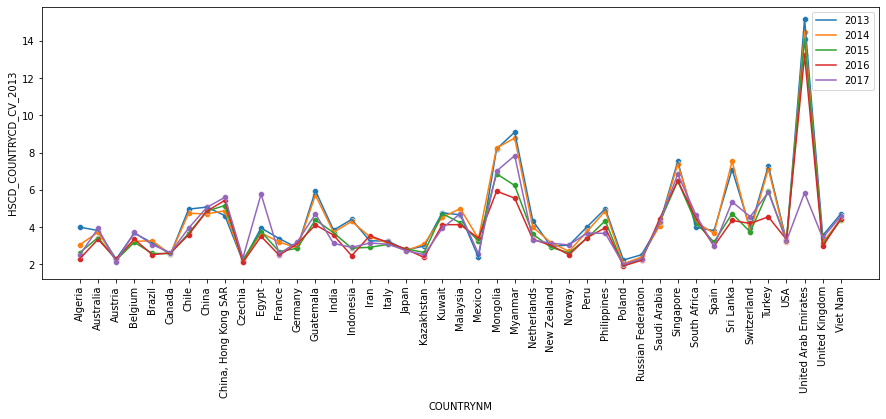

In [28]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[총수입액]**

In [29]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f = train_test.groupby('COUNTRYNM')[column].agg([
        (f'HSCD_COUNTRYCD_SUM_{num}', np.sum),   # 총수입액
#        (f'HSCD_COUNTRYCD_MEAN_{num}', np.mean), # 총 수입액과 평균수입액이 차이가 나지 않아 총 수입액만 가져가도록 한다.
    ]).reset_index()
    df_lst.append(f); f
    
f = pd.concat(df_lst, axis=1).drop('COUNTRYNM', axis=1).set_index(cv_df['COUNTRYNM']).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,HSCD_COUNTRYCD_SUM_2013,HSCD_COUNTRYCD_SUM_2014,HSCD_COUNTRYCD_SUM_2015,HSCD_COUNTRYCD_SUM_2016,HSCD_COUNTRYCD_SUM_2017
0,Algeria,3.851168e+10,3.795768e+10,3.291625e+10,3.021977e+10,2.941010e+10
1,Australia,2.389247e+11,2.360922e+11,2.155668e+11,1.983889e+11,2.467444e+11
2,Austria,1.404041e+11,1.425440e+11,1.240354e+11,1.306937e+11,1.511120e+11
3,Belgium,2.324334e+11,2.318111e+11,1.948445e+11,2.097180e+11,3.115199e+11
4,Brazil,2.113844e+11,1.979531e+11,1.443193e+11,1.181044e+11,1.379470e+11


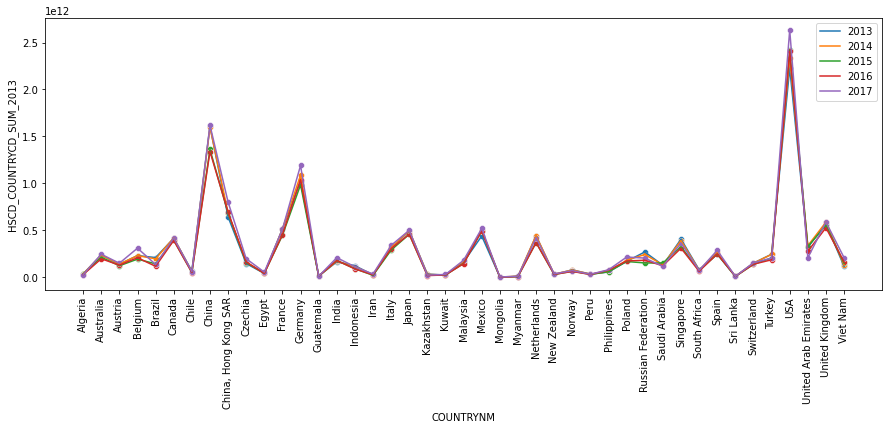

In [30]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[최대수입액]**

In [31]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f = train_test.groupby('COUNTRYNM')[column].agg([
        (f'HSCD_COUNTRYCD_MAX_{num}', np.max)    # 최대수입액
    ]).reset_index()
    df_lst.append(f); f
    
f = pd.concat(df_lst, axis=1).drop('COUNTRYNM', axis=1).set_index(cv_df['COUNTRYNM']).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,HSCD_COUNTRYCD_MAX_2013,HSCD_COUNTRYCD_MAX_2014,HSCD_COUNTRYCD_MAX_2015,HSCD_COUNTRYCD_MAX_2016,HSCD_COUNTRYCD_MAX_2017
0,Algeria,2.515753e+09,1.538449e+09,1.037978e+09,7.559965e+08,1.261957e+09
1,Australia,1.472089e+10,1.392638e+10,1.060225e+10,8.625427e+09,1.600636e+10
2,Austria,4.634368e+09,4.569134e+09,4.116567e+09,4.727099e+09,4.593398e+09
3,Belgium,1.387887e+10,9.683695e+09,8.278670e+09,9.520416e+09,1.521573e+10
4,Brazil,1.124200e+10,1.132023e+10,5.044320e+09,4.081859e+09,7.615167e+09


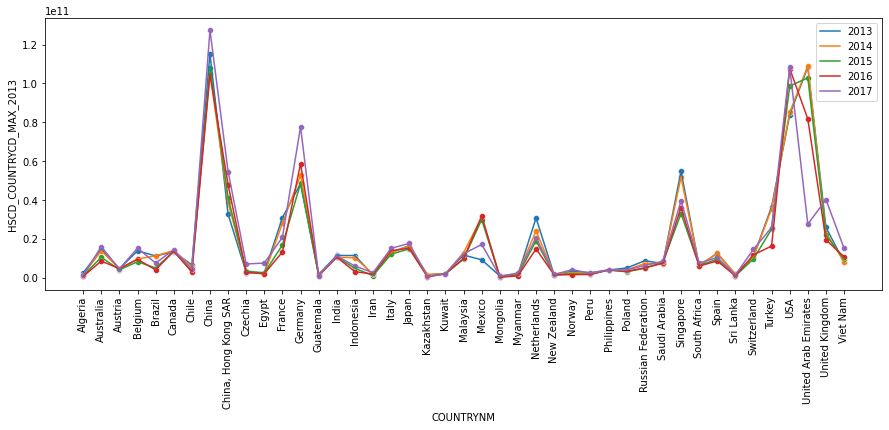

In [32]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[최대수입액변화량]**

In [33]:
# 1. 총 수입액의 변화량 -> 이전 연도 TRADE_HSCD_COUNTRYCD 증감률과 동일하여 제거
#sum_col_lst = ['HSCD_COUNTRYCD_SUM_2014', 'HSCD_COUNTRYCD_SUM_2015', 'HSCD_COUNTRYCD_SUM_2016', 'HSCD_COUNTRYCD_SUM_2017']
#for num, col in enumerate(sum_col_lst, 13):    
#    f2[f'HSCD_COUNTRYCD_SUM_DIFF{num+1}{num}'] = (f[col] - f[f'HSCD_COUNTRYCD_SUM_20{num}']) / f[f'HSCD_COUNTRYCD_SUM_20{num}']
    

# 2. 평균수입액의 변화량 -> 총 수입액과 상관관계가 매우 동일하여 제거
#mean_col_lst = ['HSCD_COUNTRYCD_MEAN_2014', 'HSCD_COUNTRYCD_MEAN_2015', 'HSCD_COUNTRYCD_MEAN_2016', 'HSCD_COUNTRYCD_MEAN_2017']
#for num, col in enumerate(mean_col_lst, 13):    
#    f2[f'HSCD_COUNTRYCD_MEAN_DIFF{num+1}{num}'] = (f[col] - f[f'HSCD_COUNTRYCD_MEAN_20{num}']) / f[f'HSCD_COUNTRYCD_MEAN_20{num}']


# 3. 최대수입액의 변화량
f2 = f.copy()
max_col_lst = ['HSCD_COUNTRYCD_MAX_2014', 'HSCD_COUNTRYCD_MAX_2015', 'HSCD_COUNTRYCD_MAX_2016', 'HSCD_COUNTRYCD_MAX_2017']
for num, col in enumerate(max_col_lst, 13):    
    f2[f'HSCD_MAX_DIFF{num+1}{num}'] = (f[col] - f[f'HSCD_COUNTRYCD_MAX_20{num}']) / f[f'HSCD_COUNTRYCD_MAX_20{num}']
    
f = f2.loc[:, 'HSCD_MAX_DIFF1413':].set_index(cv_df['COUNTRYNM']).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,HSCD_MAX_DIFF1413,HSCD_MAX_DIFF1514,HSCD_MAX_DIFF1615,HSCD_MAX_DIFF1716
0,Algeria,-0.388474,-0.325309,-0.271664,0.669262
1,Australia,-0.053972,-0.238693,-0.186453,0.855718
2,Austria,-0.014076,-0.099049,0.148311,-0.028284
3,Belgium,-0.302270,-0.145092,0.149993,0.598221
4,Brazil,0.006958,-0.554398,-0.190801,0.865612


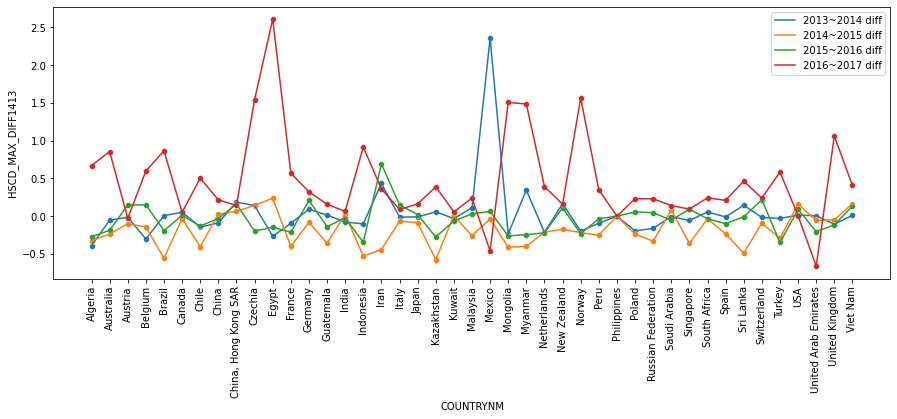

In [34]:
plt.figure(figsize=(15, 5))
labels = [f'{i}~{i+1} diff' for i in range(2013, 2017)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[금액의90퍼차지품목수입비율]**

In [35]:
TRADE_HSCD_COUNTRYCD_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, TRADE_HSCD_COUNTRYCD in enumerate(TRADE_HSCD_COUNTRYCD_lst, 2013):
    TRADE_HSCD_COUNTRYCD_TOTAL = train_test[TRADE_HSCD_COUNTRYCD].sum()
    hscd_bs220 = train_test.groupby('HSCD')[TRADE_HSCD_COUNTRYCD].sum().sort_values(ascending=False).index[:220].tolist()
    hscd_bs220_df = (train_test.query('HSCD in @hscd_bs220').groupby(['COUNTRYNM'])[TRADE_HSCD_COUNTRYCD].sum() / TRADE_HSCD_COUNTRYCD_TOTAL).reset_index(name=f'HSCD_BS220_ratio_{num}')
    df_lst.append(hscd_bs220_df[f'HSCD_BS220_ratio_{num}'])

f = pd.concat(df_lst, axis=1).set_index(hscd_bs220_df['COUNTRYNM']).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,HSCD_BS220_ratio_2013,HSCD_BS220_ratio_2014,HSCD_BS220_ratio_2015,HSCD_BS220_ratio_2016,HSCD_BS220_ratio_2017
0,Algeria,0.002751,0.002603,0.002398,0.002156,0.001887
1,Australia,0.016959,0.016281,0.016002,0.014733,0.016297
2,Austria,0.009348,0.009244,0.008683,0.009220,0.009484
3,Belgium,0.016182,0.015703,0.014236,0.015444,0.020413
4,Brazil,0.014702,0.013373,0.010387,0.008561,0.008868


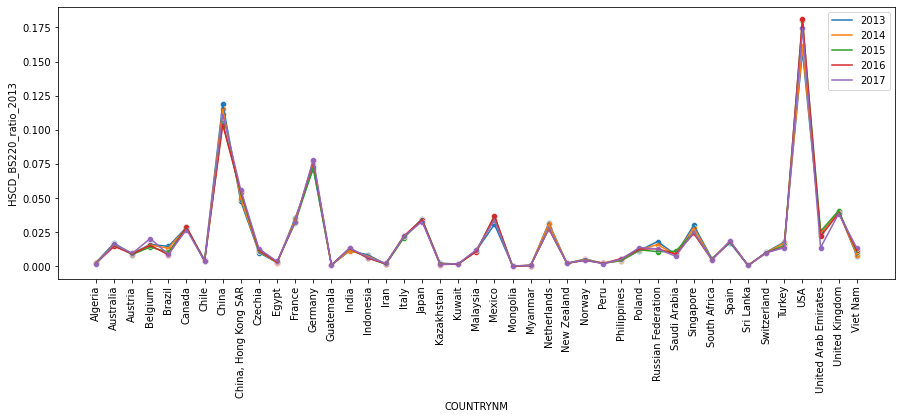

In [36]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[상위100품목수입비율]**

In [37]:
best_seller = list(train_test.HSCD.value_counts().index[:100])

BS100_HSCD_COUNTRYCD = train_test.query('HSCD in @best_seller').groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum()
ALL_HSCD_COUNTRYCD = train_test.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum()
BS100_HSCD_COUNTRYCD_RATIO = BS100_HSCD_COUNTRYCD / ALL_HSCD_COUNTRYCD
f = BS100_HSCD_COUNTRYCD_RATIO.reset_index(name='BS100_HSCD_COUNTRYCD_RATIO')
country_f_lst.append(f); f.head()

,COUNTRYNM,BS100_HSCD_COUNTRYCD_RATIO
0,Algeria,0.300995
1,Australia,0.278924
2,Austria,0.230427
3,Belgium,0.223947
4,Brazil,0.290598


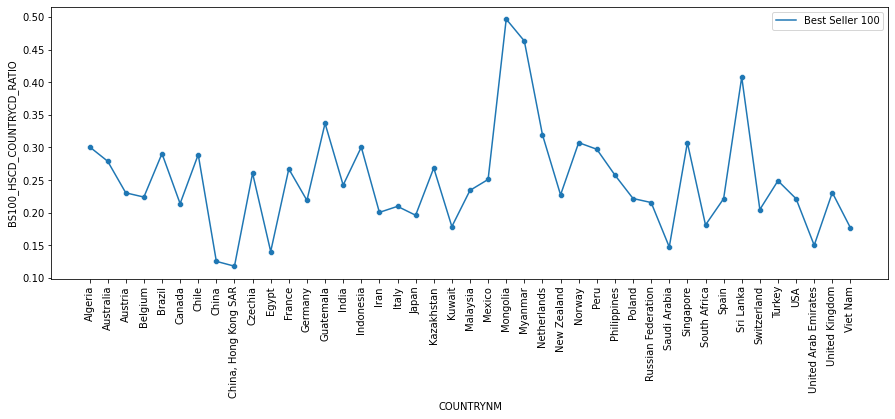

In [38]:
plt.figure(figsize=(15, 5))
sns.scatterplot(y = f.iloc[:, 1], x=f.iloc[:, 0])
sns.lineplot(y = f.iloc[:, 1], x=f.iloc[:, 0], label='Best Seller 100')

plt.xticks(rotation=90)
plt.show()

**[이전연도대비TRADE_COUNTRYCD증감률]**

In [39]:
import13 = train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD_2013'].mean()
import14 = train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD_2014'].mean()
import15 = train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD_2015'].mean()
import16 = train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD_2016'].mean()
import17 = train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].mean()

In [40]:
increase14_ratio = ((import14 - import13) / import13).reset_index(name='TRADE_COUNTRYCD_InDecrease_1413') 
increase15_ratio = ((import15 - import14) / import14).reset_index(name='TRADE_COUNTRYCD_InDecrease_1514') 
increase16_ratio = ((import16 - import15) / import15).reset_index(name='TRADE_COUNTRYCD_InDecrease_1615') 
increase17_ratio = ((import17 - import16) / import16).reset_index(name='TRADE_COUNTRYCD_InDecrease_1716')

f = pd.concat([increase14_ratio, increase15_ratio, increase16_ratio, increase17_ratio], axis=1).drop('COUNTRYNM', axis=1).set_index(increase14_ratio.COUNTRYNM).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,TRADE_COUNTRYCD_InDecrease_1413,TRADE_COUNTRYCD_InDecrease_1514,TRADE_COUNTRYCD_InDecrease_1615,TRADE_COUNTRYCD_InDecrease_1716
0,Algeria,0.067531,-0.116261,-0.090967,-0.062988
1,Australia,-0.021236,-0.120548,-0.053509,0.237723
2,Austria,-0.005301,-0.142183,0.013919,0.178236
3,Belgium,0.001381,-0.212651,0.304114,0.286726
4,Brazil,-0.045659,-0.250479,-0.195110,0.156779


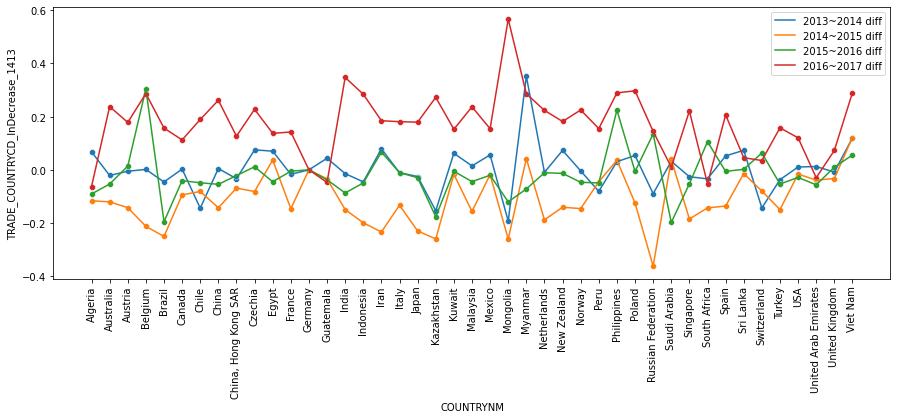

In [41]:
plt.figure(figsize=(15, 5))
labels = [f'{i}~{i+1} diff' for i in range(2013, 2017)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[이전연도대비TRADE_HSCD증감률]**

In [42]:
import15 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_2015'].mean()
import16 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_2016'].mean()
import17 = train_test.groupby('COUNTRYNM')['TRADE_HSCD'].mean()

increase16 = ((import16-import15) / import15).reset_index(name='TRADE_HSCD_InDecrease_1516').fillna(0)
increase17 = ((import17-import16) / import16).reset_index(name='TRADE_HSCD_InDecrease_1617').replace(np.inf, 0)

f = pd.concat([increase16, increase17.iloc[:, 1]], axis=1)
country_f_lst.append(f); f.head()

,COUNTRYNM,TRADE_HSCD_InDecrease_1516,TRADE_HSCD_InDecrease_1617
0,Algeria,0.005635,0.178345
1,Australia,0.006485,0.169825
2,Austria,0.005977,0.169882
3,Belgium,0.006796,0.169523
4,Brazil,0.010009,0.182046


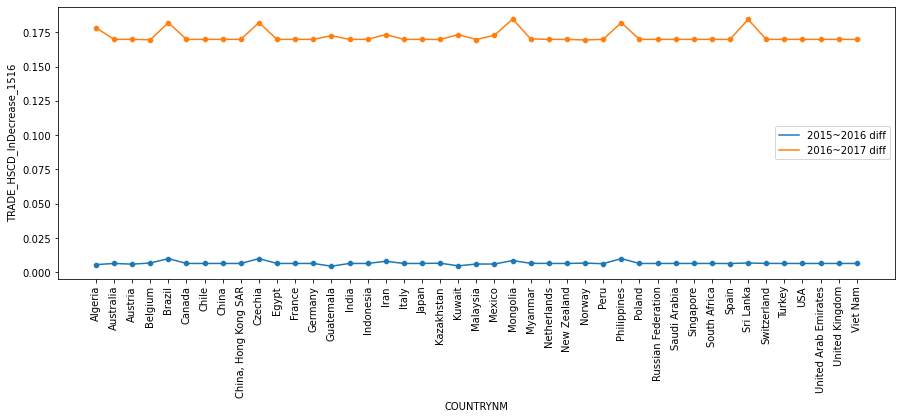

In [43]:
plt.figure(figsize=(15, 5))
labels = [f'{i}~{i+1} diff' for i in range(2015, 2017)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[이전연도대비TRADE_HSCD_COUNTRYCD증감률]**

In [44]:
import13 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD_2013'].mean()
import14 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD_2014'].mean()
import15 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD_2015'].mean()
import16 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD_2016'].mean()
import17 = train_test.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].mean()

increase14 = ((import14-import13) / import13).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1413') 
increase15 = ((import15-import14) / import14).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1514') 
increase16 = ((import16-import15) / import15).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1615') 
increase17 = ((import17-import16) / import16).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1716') 

f = pd.concat([increase14, increase15.iloc[:, 1], increase16.iloc[:, 1], increase17.iloc[:, 1]], axis=1)
country_f_lst.append(f); f.head()

,COUNTRYNM,TRADE_HSCD_COUNTRYCD_InDecrease_1413,TRADE_HSCD_COUNTRYCD_InDecrease_1514,TRADE_HSCD_COUNTRYCD_InDecrease_1615,TRADE_HSCD_COUNTRYCD_InDecrease_1716
0,Algeria,-0.014385,-0.132817,-0.081919,-0.026793
1,Australia,-0.011855,-0.086938,-0.079687,0.243741
2,Austria,0.015241,-0.129845,0.053681,0.156230
3,Belgium,-0.002678,-0.159468,0.076335,0.485423
4,Brazil,-0.063540,-0.270942,-0.181645,0.168010


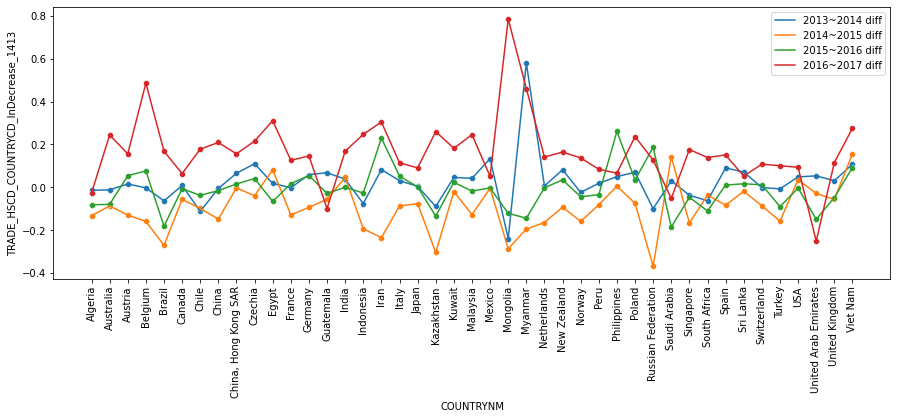

In [45]:
plt.figure(figsize=(15, 5))
labels = [f'{i}~{i+1} diff' for i in range(2013, 2017)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[구매HSCD종류, 구매HSCD_name종류]**

In [46]:
f = train_test.groupby('COUNTRYNM').agg({
    'HSCD' : [('HSCD_pur_variance', lambda x: x.nunique()/500)],
    'HSCD_name' : [('HSCD_name_pur_variance', lambda x: x.nunique()/239)]
})

f.columns = f.columns.droplevel()
f = f.reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,HSCD_pur_variance,HSCD_name_pur_variance
0,Algeria,0.808,0.811715
1,Australia,1.000,1.000000
2,Austria,0.998,0.995816
3,Belgium,0.986,0.987448
4,Brazil,0.998,0.995816


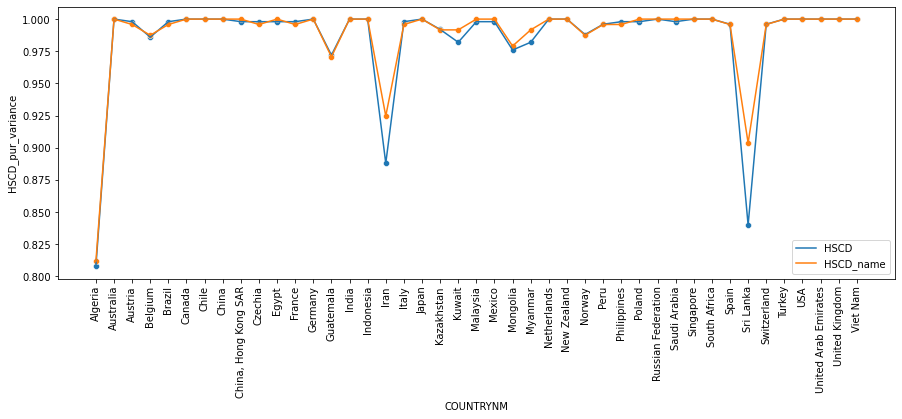

In [47]:
plt.figure(figsize=(15, 5))
labels = ['HSCD', 'HSCD_name']
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

<font color = 'green'>

### 대륙별 피쳐 (8 by x)
 - 아시아는 서아시아, 중앙아시아, 동남아시아로 나누었음

In [49]:
continent_f_lst = []

**[TRADE_HSCD_COUNTRYCD변동계수]**

In [50]:
columns_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(columns_lst, 2013):
    hscd_countrycd_cv = train_test.groupby('CONTINENT')[column].std() / train_test.groupby('CONTINENT')[column].mean()
    cv_df = hscd_countrycd_cv.reset_index(name=f'HSCD_COUNTRYCD_CV_{num}_ctn')
    df_lst.append(cv_df[f'HSCD_COUNTRYCD_CV_{num}_ctn'])

f = pd.concat(df_lst, axis=1).set_index(cv_df['CONTINENT']).reset_index()
continent_f_lst.append(f); f

,CONTINENT,HSCD_COUNTRYCD_CV_2013_ctn,HSCD_COUNTRYCD_CV_2014_ctn,HSCD_COUNTRYCD_CV_2015_ctn,HSCD_COUNTRYCD_CV_2016_ctn,HSCD_COUNTRYCD_CV_2017_ctn
0,Africa,4.200263,4.318578,4.232351,4.312740,5.146101
1,CentralAsia,7.125625,6.763397,7.012491,6.992787,7.387702
2,EastSouthAsia,9.122980,8.715651,7.256719,6.969784,7.259276
3,Europe,4.184445,3.998362,3.839922,3.953186,4.083687
4,NorthAmerica,5.318913,5.232633,5.431954,5.561797,5.460156
5,Oceania,4.848885,4.689147,4.343655,4.175893,4.909795
6,SouthAmerica,4.259931,4.301712,3.340898,3.206050,3.770352
7,WestAsia,14.708072,14.288096,13.644718,12.031497,6.081439


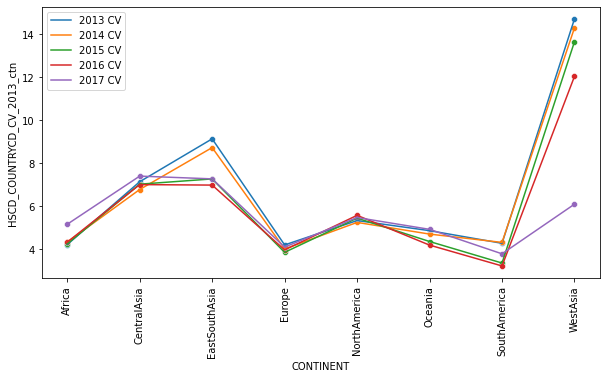

In [51]:
plt.figure(figsize=(10, 5))
labels = [f'{i} CV' for i in range(2013, 2018)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x = f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[총수입액]**

In [52]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f1 = train_test.groupby('CONTINENT')[column].agg([
        (f'HSCD_COUNTRYCD_SUM_{num}_ctn', np.sum)
    ]).reset_index()
    df_lst.append(f1); f1
    
f1 = pd.concat(df_lst, axis=1).drop('CONTINENT', axis=1).set_index(cv_df['CONTINENT']).reset_index()
continent_f_lst.append(f1); f1    

,CONTINENT,HSCD_COUNTRYCD_SUM_2013_ctn,HSCD_COUNTRYCD_SUM_2014_ctn,HSCD_COUNTRYCD_SUM_2015_ctn,HSCD_COUNTRYCD_SUM_2016_ctn,HSCD_COUNTRYCD_SUM_2017_ctn
0,Africa,1.239467e+11,1.195384e+11,1.202357e+11,1.089910e+11,1.315181e+11
1,CentralAsia,3.058554e+12,3.062016e+12,2.683763e+12,2.698512e+12,3.158563e+12
2,EastSouthAsia,8.810409e+11,8.836157e+11,7.920168e+11,7.995687e+11,9.674237e+11
3,Europe,4.040994e+12,4.179826e+12,3.752526e+12,3.836024e+12,4.453897e+12
4,NorthAmerica,3.139259e+12,3.309513e+12,3.358951e+12,3.341901e+12,3.614298e+12
5,Oceania,2.709720e+11,2.707515e+11,2.470090e+11,2.309108e+11,2.846031e+11
6,SouthAmerica,3.143120e+11,2.938627e+11,2.313684e+11,2.019828e+11,2.338036e+11
7,WestAsia,9.265462e+11,9.561674e+11,9.272461e+11,8.369121e+11,8.232387e+11


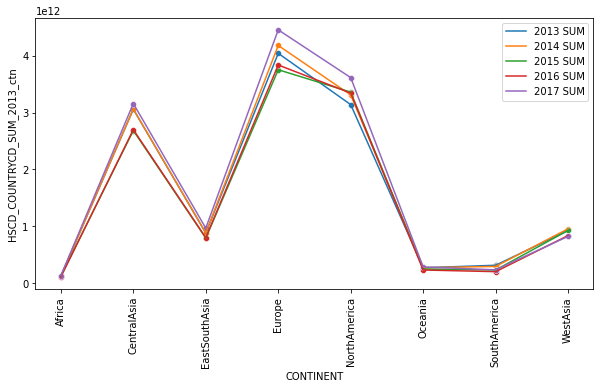

In [53]:
plt.figure(figsize=(10, 5))
labels = [f'{i} SUM' for i in range(2013, 2018)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f1.iloc[:, i], x = f1.iloc[:, 0])
    sns.lineplot(y = f1.iloc[:, i], x=f1.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[평균수입액]**

In [54]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f2 = train_test.groupby('CONTINENT')[column].agg([
        (f'HSCD_COUNTRYCD_MEAN_{num}_ctn', np.mean)
    ]).reset_index()
    df_lst.append(f2); f2
    
f2 = pd.concat(df_lst, axis=1).drop('CONTINENT', axis=1).set_index(cv_df['CONTINENT']).reset_index()
continent_f_lst.append(f2); f2

,CONTINENT,HSCD_COUNTRYCD_MEAN_2013_ctn,HSCD_COUNTRYCD_MEAN_2014_ctn,HSCD_COUNTRYCD_MEAN_2015_ctn,HSCD_COUNTRYCD_MEAN_2016_ctn,HSCD_COUNTRYCD_MEAN_2017_ctn
0,Africa,6.203539e+07,5.982902e+07,6.017802e+07,5.455007e+07,6.582489e+07
1,CentralAsia,5.126640e+08,5.132445e+08,4.498429e+08,4.523151e+08,5.294272e+08
2,EastSouthAsia,1.473805e+08,1.478113e+08,1.324886e+08,1.337519e+08,1.618307e+08
3,Europe,3.379888e+08,3.496007e+08,3.138613e+08,3.208451e+08,3.725240e+08
4,NorthAmerica,6.570237e+08,6.926566e+08,7.030036e+08,6.994351e+08,7.564458e+08
5,Oceania,1.354860e+08,1.353757e+08,1.235045e+08,1.154554e+08,1.423015e+08
6,SouthAmerica,1.049806e+08,9.815053e+07,7.727735e+07,6.746251e+07,7.809073e+07
7,WestAsia,1.381256e+08,1.425414e+08,1.382299e+08,1.247633e+08,1.227249e+08


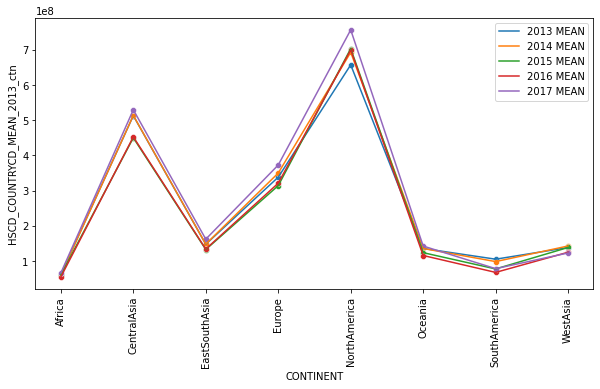

In [55]:
plt.figure(figsize=(10, 5))
labels = [f'{i} MEAN' for i in range(2013, 2018)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f2.iloc[:, i], x = f2.iloc[:, 0])
    sns.lineplot(y = f2.iloc[:, i], x=f2.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[최대수입액]**

In [56]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f3 = train_test.groupby('CONTINENT')[column].agg([
        (f'HSCD_COUNTRYCD_MAX_{num}_ctn', np.max)  
    ]).reset_index()
    df_lst.append(f3); f3
    
f3 = pd.concat(df_lst, axis=1).drop('CONTINENT', axis=1).set_index(cv_df['CONTINENT']).reset_index()
continent_f_lst.append(f3); f3

,CONTINENT,HSCD_COUNTRYCD_MAX_2013_ctn,HSCD_COUNTRYCD_MAX_2014_ctn,HSCD_COUNTRYCD_MAX_2015_ctn,HSCD_COUNTRYCD_MAX_2016_ctn,HSCD_COUNTRYCD_MAX_2017_ctn
0,Africa,6.153056e+09,6.495800e+09,6.262406e+09,6.046662e+09,7.590412e+09
1,CentralAsia,1.153200e+11,1.052270e+11,1.080990e+11,1.047490e+11,1.274310e+11
2,EastSouthAsia,5.483226e+10,5.171331e+10,3.308105e+10,3.614683e+10,3.953318e+10
3,Europe,4.848050e+10,5.291059e+10,4.855815e+10,5.872966e+10,7.769871e+10
4,NorthAmerica,8.385790e+10,8.507419e+10,9.865350e+10,1.076520e+11,1.082820e+11
5,Oceania,1.472089e+10,1.392638e+10,1.060225e+10,8.625427e+09,1.600636e+10
6,SouthAmerica,1.124200e+10,1.132023e+10,5.044320e+09,4.081859e+09,7.615167e+09
7,WestAsia,1.084540e+11,1.090030e+11,1.028770e+11,8.169165e+10,2.757874e+10


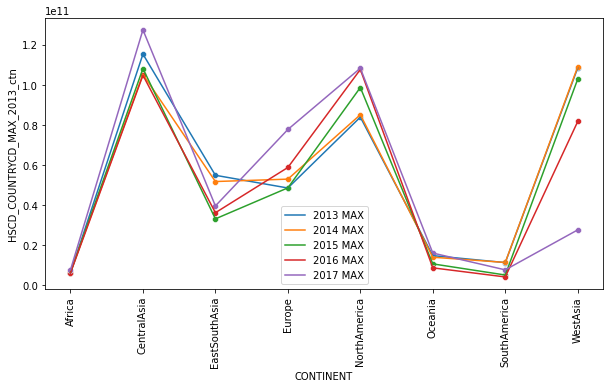

In [57]:
plt.figure(figsize=(10, 5))
labels = [f'{i} MAX' for i in range(2013, 2018)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f3.iloc[:, i], x = f3.iloc[:, 0])
    sns.lineplot(y = f3.iloc[:, i], x=f3.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[최대수입액변화량]**

In [58]:
# 1. 총 수입액의 변화량
#f4 = f.copy()
#sum_col_lst = ['HSCD_COUNTRYCD_SUM_2014', 'HSCD_COUNTRYCD_SUM_2015', 'HSCD_COUNTRYCD_SUM_2016', 'HSCD_COUNTRYCD_SUM_2017']
#for num, col in enumerate(sum_col_lst, 13):    
#    f4[f'HSCD_COUNTRYCD_SUM_DIFF_ctn{num+1}{num}'] = (f1[f'HSCD_COUNTRYCD_SUM_20{num+1}_ctn'] - f1[f'HSCD_COUNTRYCD_SUM_20{num}_ctn']) / f1[f'HSCD_COUNTRYCD_SUM_20{num}_ctn']
    

# 2. 평균수입액의 변화량
#mean_col_lst = ['HSCD_COUNTRYCD_MEAN_2014', 'HSCD_COUNTRYCD_MEAN_2015', 'HSCD_COUNTRYCD_MEAN_2016', 'HSCD_COUNTRYCD_MEAN_2017']
#for num, col in enumerate(mean_col_lst, 13):    
#    f4[f'HSCD_COUNTRYCD_MEAN_DIFF_ctn{num+1}{num}'] = (f2[f'HSCD_COUNTRYCD_MEAN_20{num+1}_ctn'] - f2[f'HSCD_COUNTRYCD_MEAN_20{num}_ctn']) / f2[f'HSCD_COUNTRYCD_MEAN_20{num}_ctn']


# 3. 최대수입액의 변화량
f4 = f.copy()
max_col_lst = ['HSCD_COUNTRYCD_MAX_2014', 'HSCD_COUNTRYCD_MAX_2015', 'HSCD_COUNTRYCD_MAX_2016', 'HSCD_COUNTRYCD_MAX_2017']
for num, col in enumerate(max_col_lst, 13):    
    f4[f'HSCD_MAX_DIFF_ctn{num+1}{num}'] = (f3[f'HSCD_COUNTRYCD_MAX_20{num+1}_ctn'] - f3[f'HSCD_COUNTRYCD_MAX_20{num}_ctn']) / f3[f'HSCD_COUNTRYCD_MAX_20{num}_ctn']
    
f = f4.iloc[:, 6:].set_index(cv_df['CONTINENT']).reset_index()
continent_f_lst.append(f); f

,CONTINENT,HSCD_MAX_DIFF_ctn1413,HSCD_MAX_DIFF_ctn1514,HSCD_MAX_DIFF_ctn1615,HSCD_MAX_DIFF_ctn1716
0,Africa,0.055703,-0.035930,-0.034451,0.255306
1,CentralAsia,-0.087522,0.027293,-0.030990,0.216537
2,EastSouthAsia,-0.056882,-0.360299,0.092675,0.093683
3,Europe,0.091379,-0.082260,0.209471,0.322989
4,NorthAmerica,0.014504,0.159617,0.091213,0.005852
5,Oceania,-0.053972,-0.238693,-0.186453,0.855718
6,SouthAmerica,0.006958,-0.554398,-0.190801,0.865612
7,WestAsia,0.005062,-0.056200,-0.205929,-0.662404


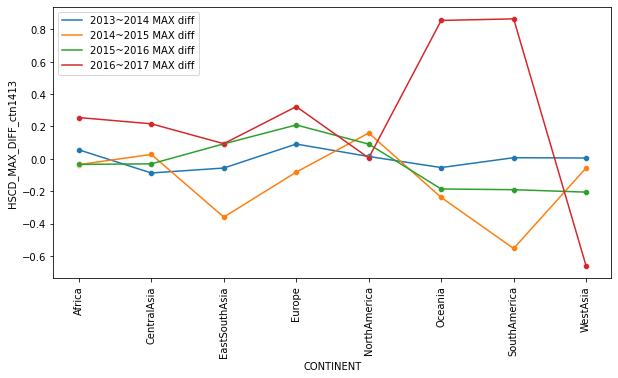

In [59]:
plt.figure(figsize=(10, 5))
labels = [f'{i}~{i+1} MAX diff' for i in range(2013, 2017)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x = f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[수입장소다양성]**

In [60]:
f = (train_test.groupby('CONTINENT')['SNDIST'].nunique() / train_test['SNDIST'].nunique()).reset_index(name='Import_place_variance_ctn')
continent_f_lst.append(f); f

,CONTINENT,Import_place_variance_ctn
0,Africa,0.047169
1,CentralAsia,0.140753
2,EastSouthAsia,0.141060
3,Europe,0.282143
4,NorthAmerica,0.112730
5,Oceania,0.047217
6,SouthAmerica,0.070660
7,WestAsia,0.158270


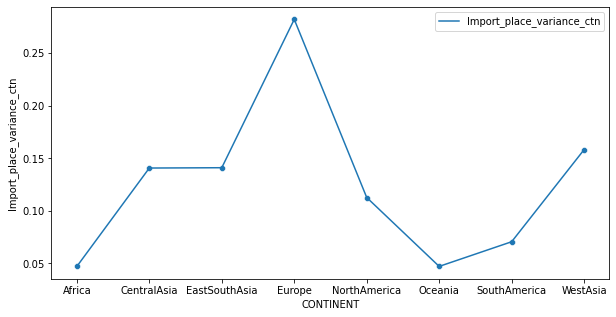

In [61]:
plt.figure(figsize=(10, 5))
sns.scatterplot(y = f.iloc[:, 1], x=f.iloc[:, 0])
sns.lineplot(y = f.iloc[:, 1], x=f.iloc[:, 0], label='Import_place_variance_ctn')

#plt.xticks(rotation=90)
plt.show()

**[금액의90퍼차지품목수입비율]**

In [62]:
TRADE_HSCD_COUNTRYCD_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, TRADE_HSCD_COUNTRYCD in enumerate(TRADE_HSCD_COUNTRYCD_lst, 2013):
    TRADE_HSCD_COUNTRYCD_TOTAL = train_test[TRADE_HSCD_COUNTRYCD].sum()
    hscd_bs220 = train_test.groupby('HSCD')[TRADE_HSCD_COUNTRYCD].sum().sort_values(ascending=False).index[:220].tolist()
    hscd_bs220_df = (train_test.query('HSCD in @hscd_bs220').groupby(['CONTINENT'])[TRADE_HSCD_COUNTRYCD].sum() / TRADE_HSCD_COUNTRYCD_TOTAL).reset_index(name=f'HSCD_BS220_ratio_{num}_ctn')
    df_lst.append(hscd_bs220_df[f'HSCD_BS220_ratio_{num}_ctn'])

f = pd.concat(df_lst, axis=1).set_index(hscd_bs220_df['CONTINENT']).reset_index()
continent_f_lst.append(f); f

,CONTINENT,HSCD_BS220_ratio_2013_ctn,HSCD_BS220_ratio_2014_ctn,HSCD_BS220_ratio_2015_ctn,HSCD_BS220_ratio_2016_ctn,HSCD_BS220_ratio_2017_ctn
0,Africa,0.008533,0.008015,0.008675,0.007881,0.008521
1,CentralAsia,0.222410,0.217069,0.205175,0.207018,0.214715
2,EastSouthAsia,0.063136,0.061554,0.058784,0.059416,0.063839
3,Europe,0.280895,0.282992,0.273777,0.280901,0.289306
4,NorthAmerica,0.220865,0.227494,0.249309,0.250034,0.238072
5,Oceania,0.019137,0.018592,0.018249,0.017071,0.018718
6,SouthAmerica,0.021802,0.019793,0.016630,0.014611,0.014992
7,WestAsia,0.066284,0.066561,0.069601,0.062817,0.053547


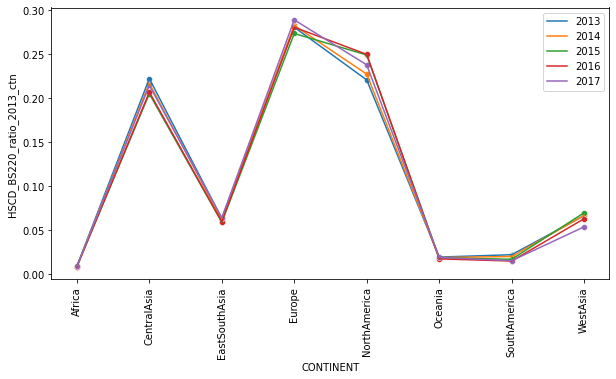

In [63]:
plt.figure(figsize=(10, 5))
labels = [f'{i}' for i in range(2013, 2018)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x = f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[상위100품목수입비율]**

In [64]:
best_seller = list(train_test.HSCD.value_counts().index[:100])

BS100_HSCD_COUNTRYCD = train_test.query('HSCD in @best_seller').groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD'].sum()
ALL_HSCD_COUNTRYCD = train_test.groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD'].sum()
BS100_HSCD_COUNTRYCD_RATIO = BS100_HSCD_COUNTRYCD / ALL_HSCD_COUNTRYCD
f = BS100_HSCD_COUNTRYCD_RATIO.reset_index(name='BS100_HSCD_COUNTRYCD_RATIO_ctn')
continent_f_lst.append(f); f

,CONTINENT,BS100_HSCD_COUNTRYCD_RATIO_ctn
0,Africa,0.163700
1,CentralAsia,0.142258
2,EastSouthAsia,0.262314
3,Europe,0.238716
4,NorthAmerica,0.225817
5,Oceania,0.272056
6,SouthAmerica,0.291150
7,WestAsia,0.204985


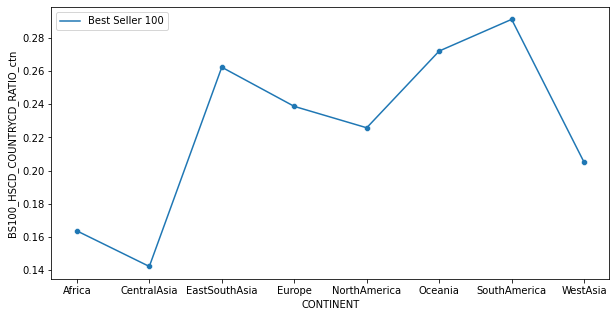

In [65]:
plt.figure(figsize=(10, 5))
sns.scatterplot(y = f.iloc[:, 1], x=f.iloc[:, 0])
sns.lineplot(y = f.iloc[:, 1], x=f.iloc[:, 0], label='Best Seller 100')

#plt.xticks(rotation=90)
plt.show()

**[이전연도대비TRADE_COUNTRYCD증감률]**

In [66]:
import13 = train_test.groupby('CONTINENT')['TRADE_COUNTRYCD_2013'].mean()
import14 = train_test.groupby('CONTINENT')['TRADE_COUNTRYCD_2014'].mean()
import15 = train_test.groupby('CONTINENT')['TRADE_COUNTRYCD_2015'].mean()
import16 = train_test.groupby('CONTINENT')['TRADE_COUNTRYCD_2016'].mean()
import17 = train_test.groupby('CONTINENT')['TRADE_COUNTRYCD'].mean()

increase14_ratio = ((import14 - import13) / import13).reset_index(name='TRADE_COUNTRYCD_InDecrease_1413_ctn') 
increase15_ratio = ((import15 - import14) / import14).reset_index(name='TRADE_COUNTRYCD_InDecrease_1514_ctn') 
increase16_ratio = ((import16 - import15) / import15).reset_index(name='TRADE_COUNTRYCD_InDecrease_1615_ctn') 
increase17_ratio = ((import17 - import16) / import16).reset_index(name='TRADE_COUNTRYCD_InDecrease_1716_ctn')

f = pd.concat([increase14_ratio, increase15_ratio, increase16_ratio, increase17_ratio], axis=1).drop('CONTINENT', axis=1).set_index(increase14_ratio.CONTINENT).reset_index()
continent_f_lst.append(f); f

,CONTINENT,TRADE_COUNTRYCD_InDecrease_1413_ctn,TRADE_COUNTRYCD_InDecrease_1514_ctn,TRADE_COUNTRYCD_InDecrease_1615_ctn,TRADE_COUNTRYCD_InDecrease_1716_ctn
0,Africa,0.006756,-0.068141,0.035880,0.028418
1,CentralAsia,-0.018406,-0.168309,-0.033628,0.212174
2,EastSouthAsia,0.006474,-0.117329,-0.008316,0.255476
3,Europe,-0.006723,-0.096148,0.018416,0.125050
4,NorthAmerica,0.015775,-0.028929,-0.030108,0.120389
5,Oceania,-0.007520,-0.123722,-0.047297,0.228768
6,SouthAmerica,-0.070596,-0.194032,-0.142833,0.164527
7,WestAsia,-0.000932,-0.096652,-0.081935,0.153209


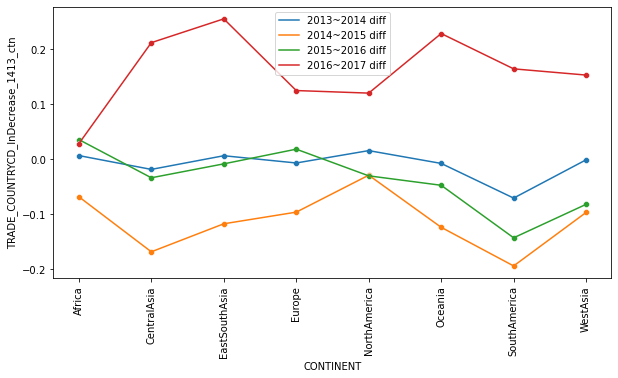

In [67]:
plt.figure(figsize=(10, 5))
labels = [f'{i}~{i+1} diff' for i in range(2013, 2017)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x = f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

**[이전연도대비TRADE_HSCD증감률]**

In [68]:
import15 = train_test.groupby('CONTINENT')['TRADE_HSCD_2015'].mean()
import16 = train_test.groupby('CONTINENT')['TRADE_HSCD_2016'].mean()
import17 = train_test.groupby('CONTINENT')['TRADE_HSCD'].mean()

increase16 = ((import16-import15) / import15).reset_index(name='TRADE_HSCD_InDecrease_1516').fillna(0)
increase17 = ((import17-import16) / import16).reset_index(name='TRADE_HSCD_InDecrease_1617').replace(np.inf, 0)

f = pd.concat([increase16, increase17.iloc[:, 1]], axis=1)
continent_f_lst.append(f); f.head()

,CONTINENT,TRADE_HSCD_InDecrease_1516,TRADE_HSCD_InDecrease_1617
0,Africa,0.006484,0.169830
1,CentralAsia,0.006838,0.172088
2,EastSouthAsia,0.006988,0.171800
3,Europe,0.006762,0.170735
4,NorthAmerica,0.005849,0.172422


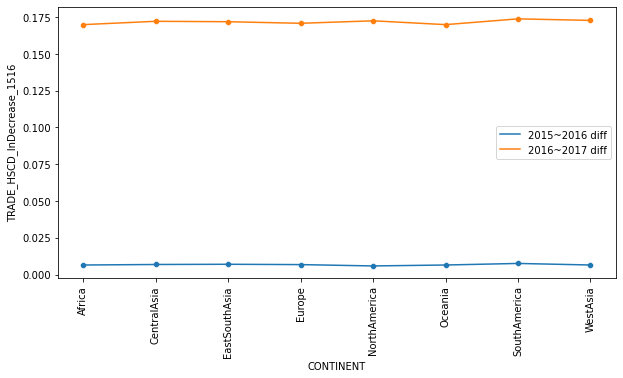

In [69]:
plt.figure(figsize=(10, 5))
labels = [f'{i}~{i+1} diff' for i in range(2015, 2017)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[이전연도대비TRADE_HSCD_COUNTRYCD증감률]**

In [70]:
import13 = train_test.groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD_2013'].mean()
import14 = train_test.groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD_2014'].mean()
import15 = train_test.groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD_2015'].mean()
import16 = train_test.groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD_2016'].mean()
import17 = train_test.groupby('CONTINENT')['TRADE_HSCD_COUNTRYCD'].mean()

increase14 = ((import14-import13) / import13).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1413_ctn') 
increase15 = ((import15-import14) / import14).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1514_ctn') 
increase16 = ((import16-import15) / import15).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1615_ctn') 
increase17 = ((import17-import16) / import16).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1716_ctn') 

f = pd.concat([increase14, increase15.iloc[:, 1], increase16.iloc[:, 1], increase17.iloc[:, 1]], axis=1)
continent_f_lst.append(f); f

,CONTINENT,TRADE_HSCD_COUNTRYCD_InDecrease_1413_ctn,TRADE_HSCD_COUNTRYCD_InDecrease_1514_ctn,TRADE_HSCD_COUNTRYCD_InDecrease_1615_ctn,TRADE_HSCD_COUNTRYCD_InDecrease_1716_ctn
0,Africa,-0.035566,0.005833,-0.093522,0.206688
1,CentralAsia,0.001132,-0.123531,0.005496,0.170483
2,EastSouthAsia,0.002922,-0.103664,0.009535,0.209932
3,Europe,0.034356,-0.102229,0.022251,0.161071
4,NorthAmerica,0.054234,0.014938,-0.005076,0.081510
5,Oceania,-0.000814,-0.087691,-0.065172,0.232524
6,SouthAmerica,-0.065061,-0.212665,-0.127008,0.157543
7,WestAsia,0.031969,-0.030247,-0.097422,-0.016338


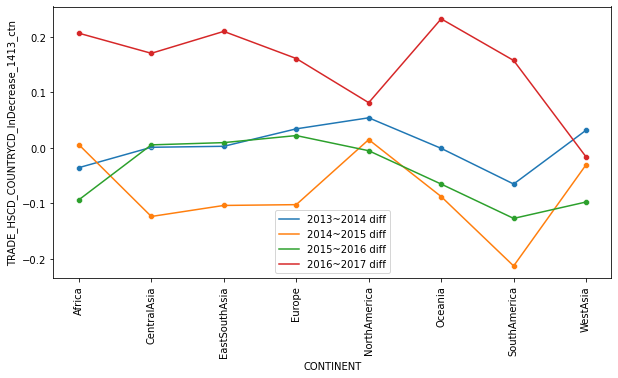

In [71]:
plt.figure(figsize=(10, 5))
labels = [f'{i}~{i+1} diff' for i in range(2013, 2017)]

for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x = f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')

plt.xticks(rotation=90)
plt.show()

<font color = 'green'>
    
### 품목 이름별 피쳐(239 by x)

In [72]:
hscd_name_f_lst = []

In [73]:
new_xticks=['etc', 'Electronic', 'Iron', 'Machinery', 'Machines', 'Petroleum oils', 'Plastics',
            'Recept&transmission', 'wireless network', 'Vehicles'] 

**[TRADE_HSCD_COUNTRYCD변동계수]**

In [74]:
columns_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, columns in enumerate(column_lst,2013):
    trade_countrycd = train_test.groupby('HSCD_name')[columns].std() / train_test.groupby('HSCD_name')[columns].mean()
    cv_df = trade_countrycd.reset_index(name=f'TRADE_COUNTRYCD_CV_{num}')
    df_lst.append(cv_df[f'TRADE_COUNTRYCD_CV_{num}'])

f = pd.concat(df_lst,axis=1).set_index(cv_df['HSCD_name']).reset_index()
hscd_name_f_lst.append(f); f.head()

,HSCD_name,TRADE_COUNTRYCD_CV_2013,TRADE_COUNTRYCD_CV_2014,TRADE_COUNTRYCD_CV_2015,TRADE_COUNTRYCD_CV_2016,TRADE_COUNTRYCD_CV_2017
0,Abrasive powder or grain,1.554970,1.582550,1.646906,1.666610,1.593618
1,Acrylic polymers,1.053969,1.103893,1.117658,1.173752,1.239894
2,Adhesives,1.828355,1.806288,1.838183,1.838107,1.858791
3,Air conditioning machines,1.766510,1.966378,1.950182,1.899901,1.996288
4,Aluminium,1.710308,1.678004,1.692485,1.708968,1.690615


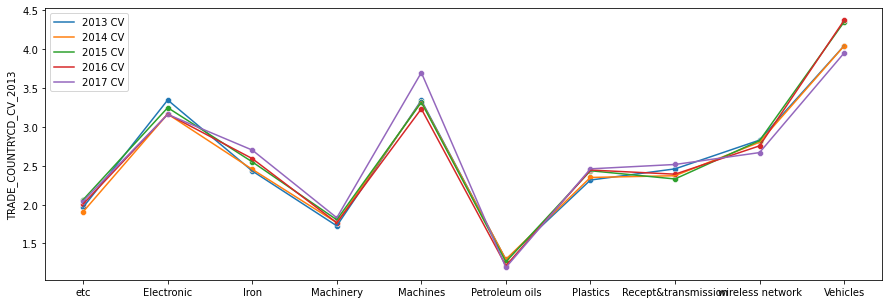

In [89]:
# 그래프는 코드를 모두 실행 시킨 뒤 hscd_top10_df를 지정해준 뒤에 실행됨

plt.figure(figsize=(15,5))
labels = [f'{i} CV' for i in range(2013,2018)]
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[총수입액]** 

In [75]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f = train_test.groupby('HSCD_name')[column].agg([
        (f'HSCD_name_SUM_{num}', np.sum),
    ]).reset_index()
    df_lst.append(f)
    
f = pd.concat(df_lst, axis=1).drop('HSCD_name', axis=1).set_index(f['HSCD_name']).reset_index()
hscd_name_f_lst.append(f); f.head()

,HSCD_name,HSCD_name_SUM_2013,HSCD_name_SUM_2014,HSCD_name_SUM_2015,HSCD_name_SUM_2016,HSCD_name_SUM_2017
0,Abrasive powder or grain,4.654907e+09,4.842382e+09,4.582418e+09,4.735100e+09,5.520928e+09
1,Acrylic polymers,2.330564e+10,2.443584e+10,2.133500e+10,2.051602e+10,2.485579e+10
2,Adhesives,1.130802e+10,1.170535e+10,1.109467e+10,1.132333e+10,1.304486e+10
3,Air conditioning machines,5.453010e+10,5.611411e+10,5.235819e+10,5.656626e+10,6.208107e+10
4,Aluminium,2.770175e+10,2.873463e+10,2.715868e+10,2.757810e+10,3.027770e+10


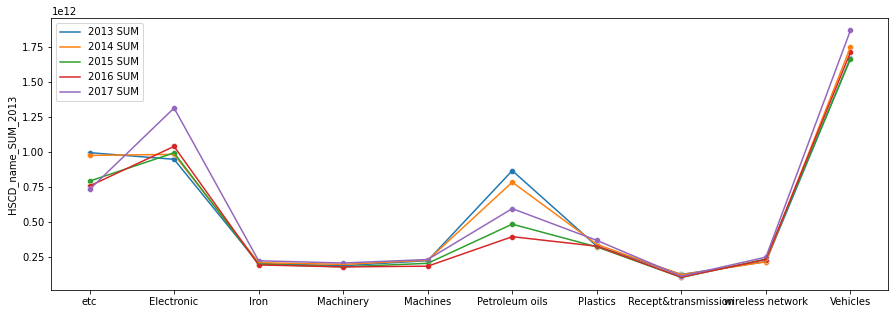

In [90]:
plt.figure(figsize=(15,5))
labels = [f'{i} SUM' for i in range(2013,2018)]
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+5],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+5],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[평균수입액]** 

In [76]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f = train_test.groupby('HSCD_name')[column].agg([
        (f'HSCD_name_MEAN_{num}', np.mean),
    ]).reset_index()
    df_lst.append(f)
    
f = pd.concat(df_lst, axis=1).drop('HSCD_name', axis=1).set_index(f['HSCD_name']).reset_index()
hscd_name_f_lst.append(f); f.head()

,HSCD_name,HSCD_name_MEAN_2013,HSCD_name_MEAN_2014,HSCD_name_MEAN_2015,HSCD_name_MEAN_2016,HSCD_name_MEAN_2017
0,Abrasive powder or grain,2.706341e+07,2.815338e+07,2.664197e+07,2.752965e+07,3.209842e+07
1,Acrylic polymers,2.709958e+08,2.841376e+08,2.480815e+08,2.385584e+08,2.890208e+08
2,Adhesives,1.314886e+08,1.361087e+08,1.290078e+08,1.316666e+08,1.516844e+08
3,Air conditioning machines,2.146854e+08,2.209217e+08,2.061346e+08,2.227018e+08,2.444137e+08
4,Aluminium,1.610567e+08,1.670618e+08,1.578993e+08,1.603378e+08,1.760331e+08


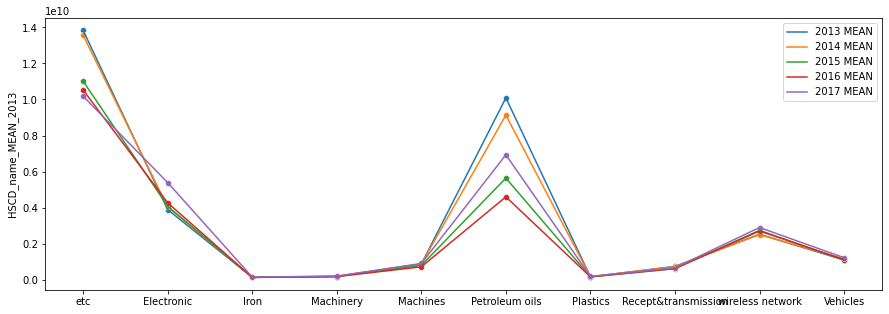

In [91]:
plt.figure(figsize=(15,5))
labels = [f'{i} MEAN' for i in range(2013,2018)]
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+10],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+10],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[최대수입액]** 

In [77]:
column_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']

df_lst = []
for num, column in enumerate(column_lst, 2013):
    f = train_test.groupby('HSCD_name')[column].agg([
        (f'HSCD_name_MAX_{num}', np.max),
    ]).reset_index()
    df_lst.append(f)
    
f = pd.concat(df_lst, axis=1).drop('HSCD_name', axis=1).set_index(f['HSCD_name']).reset_index()
hscd_name_f_lst.append(f); f.head()

,HSCD_name,HSCD_name_MAX_2013,HSCD_name_MAX_2014,HSCD_name_MAX_2015,HSCD_name_MAX_2016,HSCD_name_MAX_2017
0,Abrasive powder or grain,2.416901e+08,2.644479e+08,2.722375e+08,2.930874e+08,3.170830e+08
1,Acrylic polymers,1.377812e+09,1.540799e+09,1.421909e+09,1.502625e+09,2.152071e+09
2,Adhesives,1.514348e+09,1.550464e+09,1.490267e+09,1.536860e+09,1.803045e+09
3,Air conditioning machines,3.125309e+09,4.000769e+09,3.659653e+09,3.933508e+09,4.948300e+09
4,Aluminium,1.585521e+09,1.540243e+09,1.522995e+09,1.508772e+09,1.791015e+09


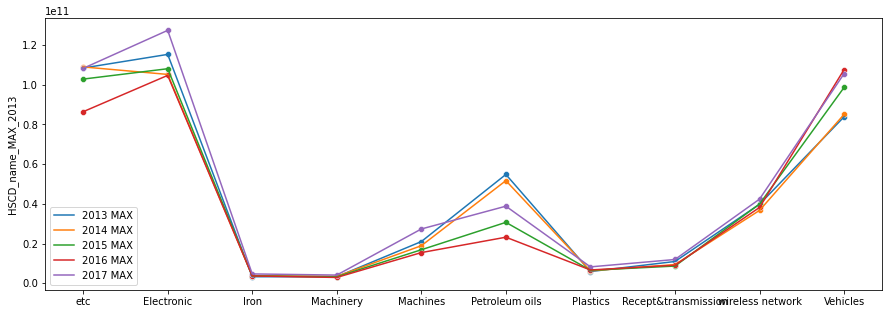

In [92]:
plt.figure(figsize=(15,5))
labels = [f'{i} MAX' for i in range(2013,2018)]
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+15],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+15],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[최대수입액변화량]** 

In [78]:
f2 = f.copy()
max_col_lst = ['HSCD_name_MAX_2014', 'HSCD_name_MAX_2015', 'HSCD_name_MAX_2016', 'HSCD_name_MAX_2017']
for num, col in enumerate(max_col_lst, 13):    
    f2[f'HSCD_MAX_DIFF{num+1}{num}'] = (f[col] - f[f'HSCD_name_MAX_20{num}']) / f[f'HSCD_name_MAX_20{num}']
    
f = f2.loc[:, 'HSCD_MAX_DIFF1413':].set_index(cv_df['HSCD_name']).reset_index()
hscd_name_f_lst.append(f); f.head()

,HSCD_name,HSCD_MAX_DIFF1413,HSCD_MAX_DIFF1514,HSCD_MAX_DIFF1615,HSCD_MAX_DIFF1716
0,Abrasive powder or grain,0.094161,0.029456,0.076587,0.081872
1,Acrylic polymers,0.118294,-0.077161,0.056766,0.432208
2,Adhesives,0.023849,-0.038825,0.031265,0.173201
3,Air conditioning machines,0.280119,-0.085262,0.074831,0.257987
4,Aluminium,-0.028557,-0.011198,-0.009339,0.187068


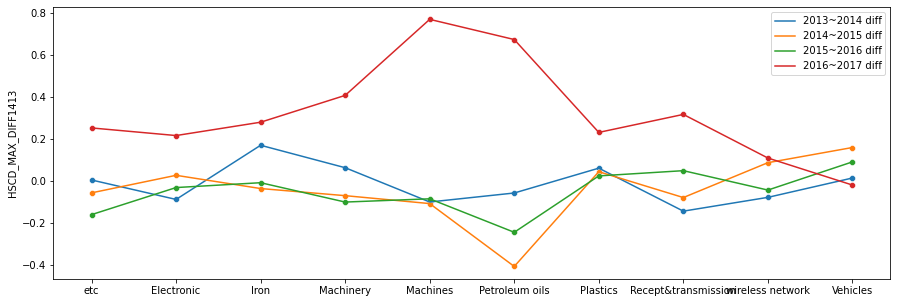

In [93]:
plt.figure(figsize=(15,5))
labels = [f'{i}~{i+1} diff' for i in range(2013,2017)]
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+20],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+20],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[수입장소다양성]**

In [79]:
f = (train_test.groupby('HSCD_name')['SNDIST'].nunique() / 1000).reset_index(name='HSCD_name_Import_place_variance')
hscd_name_f_lst.append(f); f.head()

,HSCD_name,HSCD_name_Import_place_variance
0,Abrasive powder or grain,0.172
1,Acrylic polymers,0.086
2,Adhesives,0.086
3,Air conditioning machines,0.254
4,Aluminium,0.172


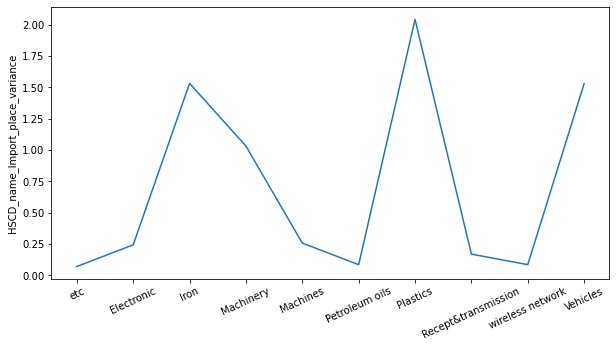

In [94]:
plt.figure(figsize=(10,5))
#sns.barplot(x=new_xticks, y=hscd_top10_df.iloc[:,6],data=hscd_top10_df,palette="Blues_d")
sns.lineplot(x=new_xticks, y=hscd_top10_df.iloc[:,25],data=hscd_top10_df)
plt.xticks(rotation=25)
plt.show()

**[한국수출10대국가수입비율]**

In [80]:
TRADE_HSCD_COUNTRYCD_lst = ['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015', 'TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD']
country_top10_lst = ['China','USA','China, Hong Kong SAR','Viet Nam','Japan','Mexico','Singapore','Germany','Australia','India']

In [81]:
# top 10 국가만 query 를 통해 뽑아준다. 
country_top10 = pd.DataFrame()
for i in country_top10_lst:
    country = train_test.query('COUNTRYNM=="%s"'%i)
    country_top10 = pd.concat([country_top10,country])

In [82]:
# 품목별 top10 국가의 수입금액 합을 구한다. 
df_lst = []
for num, TRADE_HSCD_COUNTRYCD in enumerate(TRADE_HSCD_COUNTRYCD_lst, 2013):
    f = country_top10.groupby('HSCD_name')[TRADE_HSCD_COUNTRYCD].agg([
        (f'HSCD_name_top10_sum_{num}',np.sum)
    ]).reset_index()
    df_lst.append(f)
    
f = pd.concat(df_lst,axis=1).drop('HSCD_name',axis=1).set_index(f['HSCD_name']).reset_index()

# 품목별 총 수입금액의 합 
for num, columns in enumerate(column_lst, 2013):
    f = train_test.groupby('HSCD_name')[columns].agg([
        (f'HSCD_name_sum_{num}',np.sum)
    ]).reset_index()
    df_lst.append(f)

f = pd.concat(df_lst,axis=1).drop('HSCD_name',axis=1).set_index(f['HSCD_name']).reset_index()

In [83]:
ff_lst = []
for i in [2013,2014,2015,2016,2017]:
    f_f = pd.DataFrame(f[f'HSCD_name_top10_sum_{i}'] / f[f'HSCD_name_sum_{i}'],columns = [f'HSCD_name_top10_ratio_{i}'])
    ff_lst.append(f_f)
  
f_f = pd.concat(ff_lst,axis=1).set_index(f['HSCD_name']).reset_index()
hscd_name_f_lst.append(f_f); f_f.head()

,HSCD_name,HSCD_name_top10_ratio_2013,HSCD_name_top10_ratio_2014,HSCD_name_top10_ratio_2015,HSCD_name_top10_ratio_2016,HSCD_name_top10_ratio_2017
0,Abrasive powder or grain,0.528416,0.534355,0.561828,0.556832,0.538368
1,Acrylic polymers,0.398041,0.413301,0.431800,0.458934,0.465258
2,Adhesives,0.546026,0.542718,0.565482,0.564689,0.586706
3,Air conditioning machines,0.538194,0.555253,0.559441,0.550742,0.557607
4,Aluminium,0.530615,0.514497,0.531864,0.540119,0.537858


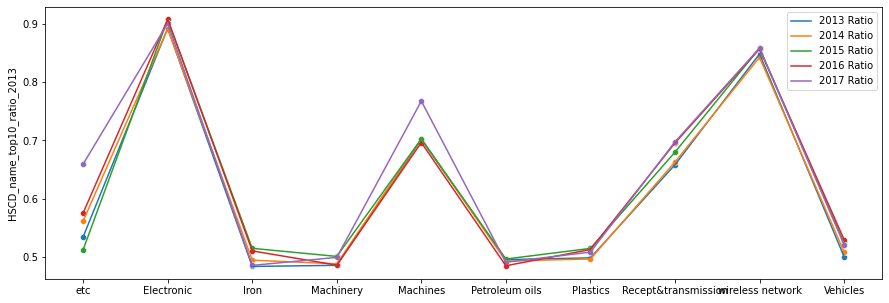

In [95]:
plt.figure(figsize=(15,5))
labels = [f'{i} Ratio' for i in range(2013,2018)]
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+25],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+25],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[이전연도대비TRADE_HSCD증감률]**

In [84]:
import15 = train_test.groupby('HSCD_name')['TRADE_HSCD_2015'].mean()
import16 = train_test.groupby('HSCD_name')['TRADE_HSCD_2016'].mean()
import17 = train_test.groupby('HSCD_name')['TRADE_HSCD'].mean()

increase16 = ((import16-import15) / import15).reset_index(name='TRADE_HSCD_InDecrease_1516').fillna(0)
increase17 = ((import17-import16) / import16).reset_index(name='TRADE_HSCD_InDecrease_1617').replace(np.inf, 0)

f = pd.concat([increase16, increase17.iloc[:, 1]], axis=1)
hscd_name_f_lst.append(f); f.head()

,HSCD_name,TRADE_HSCD_InDecrease_1516,TRADE_HSCD_InDecrease_1617
0,Abrasive powder or grain,0.035000,0.151658
1,Acrylic polymers,-0.045649,0.195747
2,Adhesives,0.018288,0.140779
3,Air conditioning machines,1.121049,0.131037
4,Aluminium,0.028515,0.095441


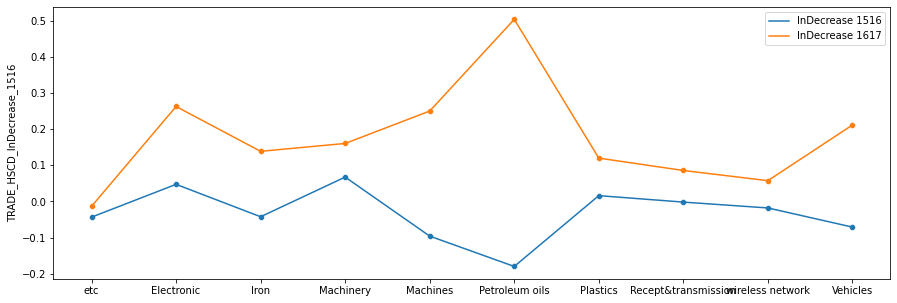

In [96]:
plt.figure(figsize=(15,5))
labels = ['InDecrease 1516','InDecrease 1617']
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+30],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+30],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[이전연도대비TRADE_COUNTRYCD증감률]**

In [85]:
import13 = train_test.groupby('HSCD_name')['TRADE_COUNTRYCD_2013'].mean()
import14 = train_test.groupby('HSCD_name')['TRADE_COUNTRYCD_2014'].mean()
import15 = train_test.groupby('HSCD_name')['TRADE_COUNTRYCD_2015'].mean()
import16 = train_test.groupby('HSCD_name')['TRADE_COUNTRYCD_2016'].mean()
import17 = train_test.groupby('HSCD_name')['TRADE_COUNTRYCD'].mean()

increase14_ratio = ((import14 - import13) / import13).reset_index(name='TRADE_COUNTRYCD_InDecrease_1413') 
increase15_ratio = ((import15 - import14) / import14).reset_index(name='TRADE_COUNTRYCD_InDecrease_1514') 
increase16_ratio = ((import16 - import15) / import15).reset_index(name='TRADE_COUNTRYCD_InDecrease_1615') 
increase17_ratio = ((import17 - import16) / import16).reset_index(name='TRADE_COUNTRYCD_InDecrease_1716')

f = pd.concat([increase14_ratio, increase15_ratio, increase16_ratio, increase17_ratio], axis=1).drop('HSCD_name', axis=1).set_index(increase14_ratio.HSCD_name).reset_index()
hscd_name_f_lst.append(f); f.head()

,HSCD_name,TRADE_COUNTRYCD_InDecrease_1413,TRADE_COUNTRYCD_InDecrease_1514,TRADE_COUNTRYCD_InDecrease_1615,TRADE_COUNTRYCD_InDecrease_1716
0,Abrasive powder or grain,-0.004842,-0.103162,-0.019165,0.155340
1,Acrylic polymers,-0.004842,-0.103162,-0.019165,0.155340
2,Adhesives,-0.004842,-0.103162,-0.019165,0.155340
3,Air conditioning machines,-0.005024,-0.103064,-0.019227,0.155257
4,Aluminium,-0.004842,-0.103162,-0.019165,0.155340


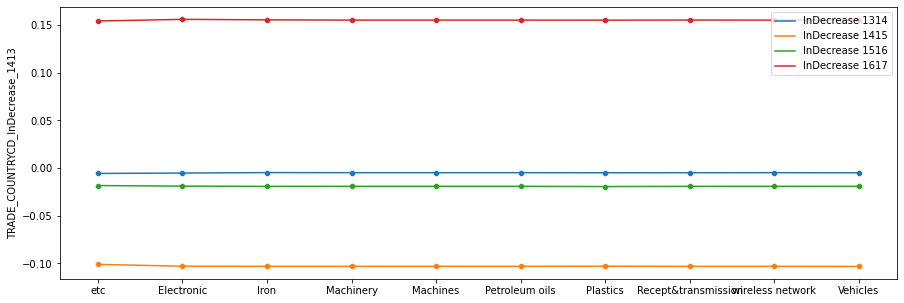

In [97]:
plt.figure(figsize=(15,5))
labels = ['InDecrease 1314','InDecrease 1415','InDecrease 1516','InDecrease 1617']
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+32],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+32],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

**[이전연도대비TRADE_HSCD_COUNTRYCD증감률]**

In [86]:
import13 = train_test.groupby('HSCD_name')['TRADE_HSCD_COUNTRYCD_2013'].mean()
import14 = train_test.groupby('HSCD_name')['TRADE_HSCD_COUNTRYCD_2014'].mean()
import15 = train_test.groupby('HSCD_name')['TRADE_HSCD_COUNTRYCD_2015'].mean()
import16 = train_test.groupby('HSCD_name')['TRADE_HSCD_COUNTRYCD_2016'].mean()
import17 = train_test.groupby('HSCD_name')['TRADE_HSCD_COUNTRYCD'].mean()

increase14 = ((import14-import13) / import13).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1314') 
increase15 = ((import15-import14) / import14).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1415')
increase16 = ((import16-import15) / import15).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1516')
increase17 = ((import17-import16) / import16).reset_index(name='TRADE_HSCD_COUNTRYCD_InDecrease_1617')

f = pd.concat([increase14, increase15.iloc[:, 1]], axis=1)
f = pd.concat([f,increase16.iloc[:,1]],axis=1)
f = pd.concat([f,increase17.iloc[:,1]],axis=1) ; f
hscd_name_f_lst.append(f); f.head()

,HSCD_name,TRADE_HSCD_COUNTRYCD_InDecrease_1314,TRADE_HSCD_COUNTRYCD_InDecrease_1415,TRADE_HSCD_COUNTRYCD_InDecrease_1516,TRADE_HSCD_COUNTRYCD_InDecrease_1617
0,Abrasive powder or grain,0.040275,-0.053685,0.033319,0.165958
1,Acrylic polymers,0.048494,-0.126897,-0.038387,0.211531
2,Adhesives,0.035136,-0.052170,0.020609,0.152034
3,Air conditioning machines,0.029048,-0.066934,0.080371,0.097493
4,Aluminium,0.037285,-0.054845,0.015443,0.097889


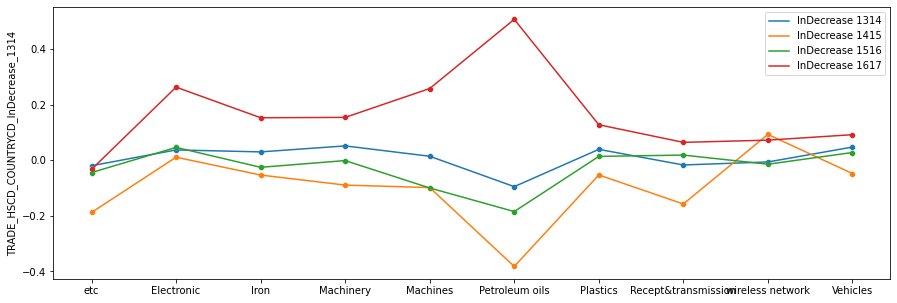

In [98]:
plt.figure(figsize=(15,5))
labels = ['InDecrease 1314','InDecrease 1415','InDecrease 1516','InDecrease 1617']
for i in range(1,len(labels)+1):
    sns.scatterplot(y=hscd_top10_df.iloc[:,i+36],x=new_xticks)
    sns.lineplot(y=hscd_top10_df.iloc[:,i+36],x=new_xticks, label = f'{labels[i-1]}')
plt.show()

In [88]:
# merge features 
HSCD_name_features = pd.concat(hscd_name_f_lst,axis=1).drop('HSCD_name',axis=1).set_index(hscd_name_f_lst[0].HSCD_name).reset_index()

In [89]:
ko_top10_lst = ['Petroleum oils and oils from bituminous minerals, not containing biodiesel, not crude, not waste oils',
       'Plastics', 'Iron or steel',
       'Commodities not specified according to kind', 'Vehicles',
       'Electronic integrated circuits',
       'Reception and transmission apparatus',
       'Telephone sets and other apparatus for the transmission or reception of voice, images or other data, via a wired or wireless network',
       'Machines', 'Machinery']

top10_short_lst = ['etc','Electronic','Iron','Machinery','Machines','Petroleum oils',
                   'Plastics','Recept&transmission','wireless network','Vehicles']

hscd_top10_df = HSCD_name_features.query('HSCD_name in @ko_top10_lst')

<font color = 'green'>

### 10대 주요물품별 피쳐 (43 by x)


**[한국 주요 수출 품목 수입 비율]**

우리나라 10대 주요 수출 품목 

- 반도체 : 반도체 미디어
- 자동차, 자동차 부품 : 차량, 차량 부품, 셀 및 배터리
- 선박해양구조물 및 부품 : 전기 모터 
- 무선통신기기 : 셀룰러 네트워크 또는 기타 무선 네트워크 용 전화
- 평판디스플레이 및 센서 : 유무선 네트워크를 통해 음성, 이미지 또는 기타 데이터를 송수신하기위한 전화 세트 및 기타 장치
- 합성수지 : 에틸렌 폴리머, 폴리 에테르, 아크릴 폴리머, 
- 철강판 : 철 또는 비 합금강, 모니터
- 석유제품 : X
- 플라스틱 제품 : X

In [90]:
ko_export10 = ["반도체 미디어","차량","차량 부품","셀 및 배터리","전기 모터","셀룰러 네트워크 또는 기타 무선 네트워크 용 전화",
             "유무선 네트워크를 통해 음성, 이미지 또는 기타 데이터를 송수신하기위한 전화 세트 및 기타 장치","에틸렌 폴리머",
             "폴리 에테르","아크릴 폴리머","철 또는 비 합금강","모니터"]

ko_export10_df = train_test.query('ko_HSCD_name in @ko_export10')
ko_export10_df_sum = ko_export10_df.groupby('COUNTRYNM')[['TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014','TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016']].sum().reset_index()


In [91]:
year_lst = [2013, 2014, 2015, 2016]
tmp_fs = []
for year in year_lst:
    f_tmp = (ko_export10_df.groupby('COUNTRYNM')[f'TRADE_HSCD_COUNTRYCD_{year}'].sum() / train_test.groupby('COUNTRYNM')[f'TRADE_COUNTRYCD_{year}'].mean()).reset_index(name=f'import_export_ko_ratio_{year}')
    tmp_fs.append(f_tmp.iloc[:, 1])
# 2017년    
f_tmp2 = (ko_export10_df.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum() / train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].mean()).reset_index(name=f'import_export_ko_ratio_2017')
tmp_fs.append(f_tmp2.iloc[:, 1])    
    
f = pd.concat(tmp_fs, axis=1).set_index(f_tmp.COUNTRYNM).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,import_export_ko_ratio_2013,import_export_ko_ratio_2014,import_export_ko_ratio_2015,import_export_ko_ratio_2016,import_export_ko_ratio_2017
0,Algeria,0.229395,0.195890,0.178268,0.153682,0.164294
1,Australia,0.238550,0.224942,0.245349,0.270963,0.249316
2,Austria,0.185900,0.187418,0.193844,0.209907,0.205747
3,Belgium,0.199846,0.202294,0.226138,0.195811,0.218324
4,Brazil,0.210614,0.201007,0.194338,0.185524,0.191069


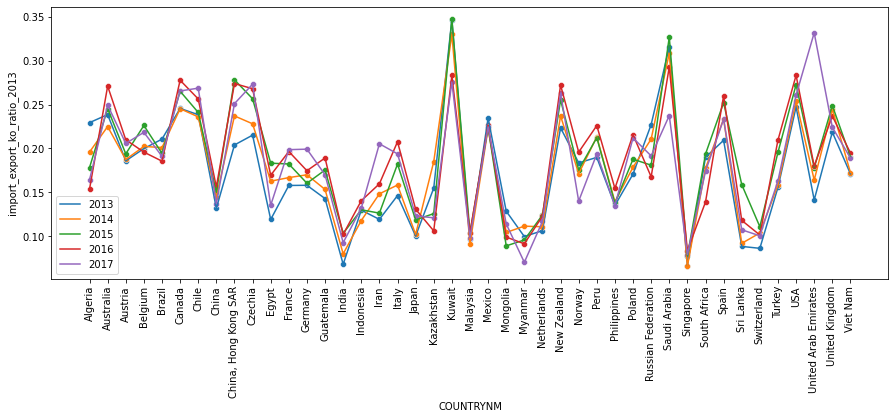

In [92]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[오일관련수입비율]**

In [93]:
oli_df = train_test.query('HSCD_name == "Petroleum oils and oils from bituminous minerals, not containing biodiesel, not crude, not waste oils"')
oli_df_sum = oli_df.groupby('COUNTRYNM')[['TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014','TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016']].sum().reset_index()


In [94]:
year_lst = [2013, 2014, 2015, 2016]
tmp_fs = []
for year in year_lst:
    f_tmp = (oli_df.groupby('COUNTRYNM')[f'TRADE_HSCD_COUNTRYCD_{year}'].sum() / train_test.groupby('COUNTRYNM')[f'TRADE_COUNTRYCD_{year}'].mean()).reset_index(name=f'export_oil_ratio_{year}')
    tmp_fs.append(f_tmp.iloc[:, 1])
# 2017년    
f_tmp2 = (oli_df.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum() / train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].mean()).reset_index(name=f'export_oil_ratio_2017')
tmp_fs.append(f_tmp2.iloc[:, 1])    
    
f = pd.concat(tmp_fs, axis=1).set_index(f_tmp.COUNTRYNM).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,export_oil_ratio_2013,export_oil_ratio_2014,export_oil_ratio_2015,export_oil_ratio_2016,export_oil_ratio_2017
0,Algeria,0.091632,0.044267,0.040074,0.022884,0.046849
1,Australia,0.126642,0.122406,0.105962,0.091079,0.119468
2,Austria,0.023581,0.021487,0.014348,0.013948,0.017202
3,Belgium,0.084632,0.058969,0.044952,0.027775,0.060324
4,Brazil,0.089123,0.094036,0.055906,0.056205,0.083241


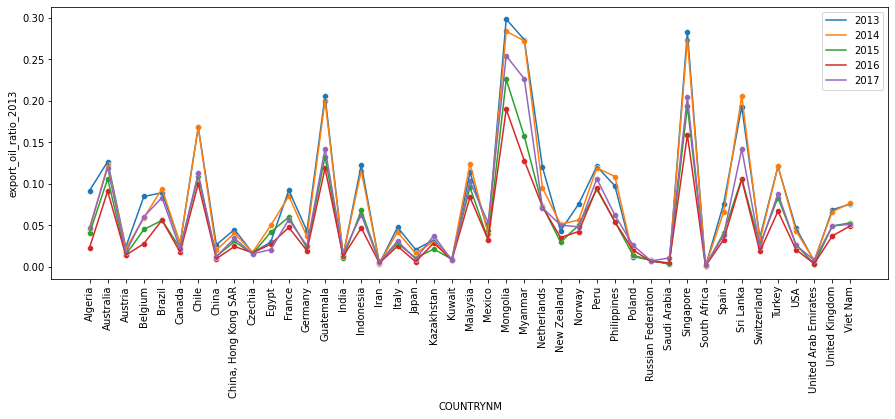

In [95]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

**[식품관련수입비율]**

: 2015 ~ 2017 시계열 데이터 

In [96]:
food_df = train_test.query('HSCD_name == "Food preparations"' or 'HSCD_name == "Sauces and preparations therefor"')
food_df_sum = food_df.groupby('COUNTRYNM')[['TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014','TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016']].sum().reset_index()


In [97]:
year_lst = [2013, 2014, 2015, 2016]
tmp_fs = []
for year in year_lst:
    f_tmp = (food_df.groupby('COUNTRYNM')[f'TRADE_HSCD_COUNTRYCD_{year}'].sum() / train_test.groupby('COUNTRYNM')[f'TRADE_COUNTRYCD_{year}'].mean()).reset_index(name=f'export_food_ratio_{year}')
    tmp_fs.append(f_tmp.iloc[:, 1])
# 2017년    
f_tmp2 = (food_df.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum() / train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].mean()).reset_index(name=f'export_food_ratio_2017')
tmp_fs.append(f_tmp2.iloc[:, 1])    
    
f = pd.concat(tmp_fs, axis=1).set_index(f_tmp.COUNTRYNM).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,export_food_ratio_2013,export_food_ratio_2014,export_food_ratio_2015,export_food_ratio_2016,export_food_ratio_2017
0,Algeria,0.008690,0.008807,0.008983,0.009507,0.008398
1,Australia,0.015567,0.015622,0.017032,0.018561,0.014632
2,Austria,0.011744,0.011947,0.012139,0.013168,0.012292
3,Belgium,0.007694,0.007892,0.008675,0.007212,0.007117
4,Brazil,0.003091,0.003279,0.003680,0.003939,0.003620


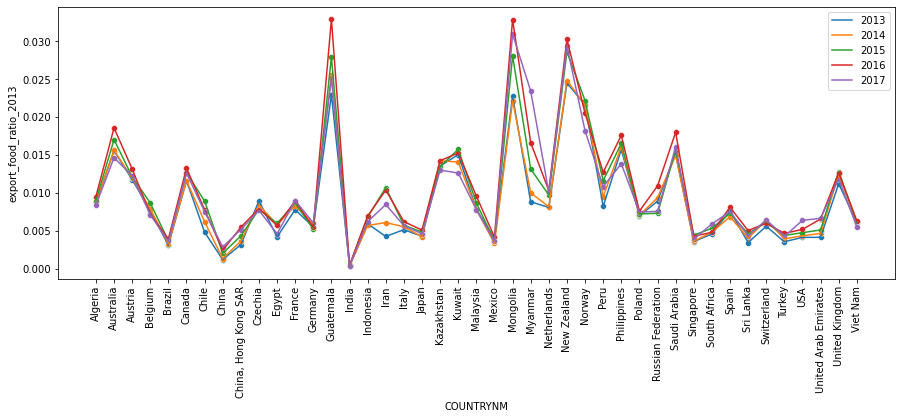

In [98]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

In [99]:
# f = train_test.query('HSCD_name == "Food preparations"' or 'HSCD_name == "Sauces and preparations therefor"')

# f = start.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD'].sum().reset_index()
# f.columns = ['COUNTRYNM','food_13','food_14', 'food_15','food_16','food_17']

# train_test = pd.merge(train_test,f,how='left',on='COUNTRYNM')

# f_1 = pd.DataFrame(train_test.food_17/ train_test.TRADE_COUNTRYCD).rename(columns={0:'food_ratio_2017'})
# f_2 = pd.DataFrame(train_test.food_16/ train_test.TRADE_COUNTRYCD_2016).rename(columns={0:'food_ratio_2016'})
# f_3 = pd.DataFrame(train_test.food_15/ train_test.TRADE_COUNTRYCD_2015).rename(columns={0:'food_ratio_2015'})
# f_4 = pd.DataFrame(train_test.food_14/ train_test.TRADE_COUNTRYCD_2014).rename(columns={0:'food_ratio_2014'})
# f_5 = pd.DataFrame(train_test.food_13/ train_test.TRADE_COUNTRYCD_2013).rename(columns={0:'food_ratio_2013'})


# features_list.append(f_1); features_list.append(f_2); features_list.append(f_3)
# features_list.append(f_4); features_list.append(f_5)
# display(f_1); display(f_2);display(f_3); display(f_4); display(f_5)

**[인쇄물관련수입비율]**

In [100]:
print_df = train_test.query('ko_HSCD_name == "인쇄물"' or 'ko_HSCD_name == "캘린더"' or 'ko_HSCD_name == "종이, 판지, 셀룰로오스 충전재 또는 섬유"' 
                   or 'ko_HSCD_name == "종이와 판지"' or 'ko_HSCD_name == "종이 기사"')
print_df_sum = print_df.groupby('COUNTRYNM')[['TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014','TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016']].sum().reset_index()


In [101]:
year_lst = [2013, 2014, 2015, 2016]
tmp_fs = []
for year in year_lst:
    f_tmp = (print_df.groupby('COUNTRYNM')[f'TRADE_HSCD_COUNTRYCD_{year}'].sum() / train_test.groupby('COUNTRYNM')[f'TRADE_COUNTRYCD_{year}'].mean()).reset_index(name=f'export_print_ratio_{year}')
    tmp_fs.append(f_tmp.iloc[:, 1])
# 2017년    
f_tmp2 = (print_df.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum() / train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].mean()).reset_index(name=f'export_print_ratio_2017')
tmp_fs.append(f_tmp2.iloc[:, 1])    
    
f = pd.concat(tmp_fs, axis=1).set_index(f_tmp.COUNTRYNM).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,export_print_ratio_2013,export_print_ratio_2014,export_print_ratio_2015,export_print_ratio_2016,export_print_ratio_2017
0,Algeria,0.002633,0.002515,0.002653,0.002607,0.001457
1,Australia,0.004744,0.004994,0.005240,0.005056,0.004389
2,Austria,0.009219,0.009284,0.008747,0.009256,0.008074
3,Belgium,0.003922,0.003790,0.003420,0.002490,0.002814
4,Brazil,0.001854,0.001838,0.002004,0.001783,0.001549


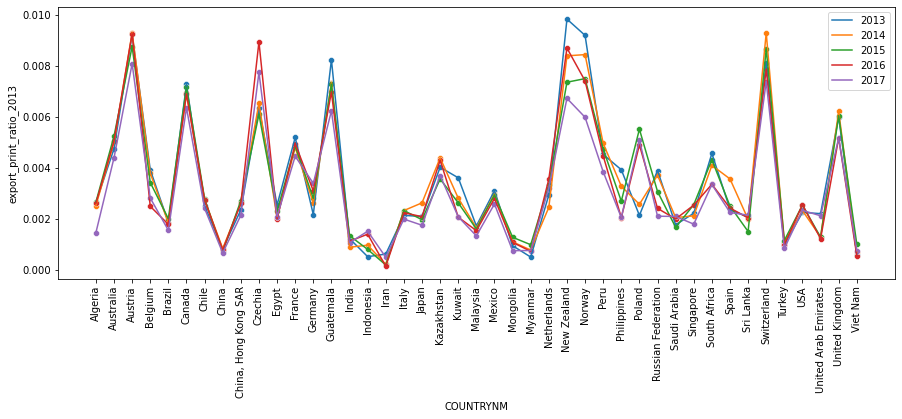

In [102]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

In [103]:
# f = train_test.query('ko_HSCD_name == "인쇄물"' or 'ko_HSCD_name == "캘린더"' or 'ko_HSCD_name == "종이, 판지, 셀룰로오스 충전재 또는 섬유"' 
#                   or 'ko_HSCD_name == "종이와 판지"' or 'ko_HSCD_name == "종이 기사"')

# f = start.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014', 'TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016', 'TRADE_HSCD_COUNTRYCD'].sum().reset_index()
# f.columns = ['COUNTRYNM','print_13', 'print_14','print_15','print_16', 'print_17']

# train_test = pd.merge(train_test,f,how='left',on='COUNTRYNM')

# f_1 = pd.DataFrame(train_test.print_17/ train_test.TRADE_COUNTRYCD).rename(columns={0:'print_ratio_2017'})
# f_2 = pd.DataFrame(train_test.print_16/ train_test.TRADE_COUNTRYCD_2016).rename(columns={0:'print_ratio_2016'})
# f_3 = pd.DataFrame(train_test.print_15/ train_test.TRADE_COUNTRYCD_2015).rename(columns={0:'print_ratio_2015'})
# f_4 = pd.DataFrame(train_test.print_14/ train_test.TRADE_COUNTRYCD_2014).rename(columns={0:'print_ratio_2014'})
# f_5 = pd.DataFrame(train_test.print_13/ train_test.TRADE_COUNTRYCD_2013).rename(columns={0:'print_ratio_2013'})

# features_list.append(f_1); features_list.append(f_2); features_list.append(f_3)
# features_list.append(f_4); features_list.append(f_5)
# display(f_1); display(f_2);display(f_3); display(f_4); display(f_5)

**[한국10대수출품목수입비율]**

In [104]:
ko_top10_export = ["전자 집적 회로","차량","원유, 폐유가 아닌 바이오 디젤을 포함하지 않는 역청 광물에서 추출한 석유 및 오일","기계","유무선 네트워크를 통해 음성, 이미지 또는 기타 데이터를 송수신하기위한 전화 세트 및 기타 장치","전자기기","플라스틱","철 또는 강철","수신 및 전송 장치","종류별로 지정되지 않은 상품"]

ko_top10_df = train_test.query('ko_HSCD_name in @ko_top10_export')
ko_top10_df_sum = ko_top10_df.groupby('COUNTRYNM')[['TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD_2013', 'TRADE_HSCD_COUNTRYCD_2014','TRADE_HSCD_COUNTRYCD_2015','TRADE_HSCD_COUNTRYCD_2016']].sum().reset_index()


In [105]:
year_lst = [2013, 2014, 2015, 2016]
tmp_fs = []
for year in year_lst:
    f_tmp = (ko_top10_df.groupby('COUNTRYNM')[f'TRADE_HSCD_COUNTRYCD_{year}'].sum() / train_test.groupby('COUNTRYNM')[f'TRADE_COUNTRYCD_{year}'].mean()).reset_index(name=f'import_export_ko_ratio_NEW_{year}')
    tmp_fs.append(f_tmp.iloc[:, 1])
# 2017년    
f_tmp2 = (ko_top10_df.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].sum() / train_test.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].mean()).reset_index(name=f'import_export_ko_ratio_NEW_2017')
tmp_fs.append(f_tmp2.iloc[:, 1])    
    
f = pd.concat(tmp_fs, axis=1).set_index(f_tmp.COUNTRYNM).reset_index()
country_f_lst.append(f); f.head()

,COUNTRYNM,import_export_ko_ratio_NEW_2013,import_export_ko_ratio_NEW_2014,import_export_ko_ratio_NEW_2015,import_export_ko_ratio_NEW_2016,import_export_ko_ratio_NEW_2017
0,Algeria,0.346098,0.270358,0.243995,0.211618,0.257279
1,Australia,0.449249,0.441215,0.443916,0.408182,0.471567
2,Austria,0.278390,0.277953,0.275497,0.296998,0.309315
3,Belgium,0.336704,0.318392,0.328301,0.265032,0.314532
4,Brazil,0.412894,0.403015,0.353298,0.335204,0.378738


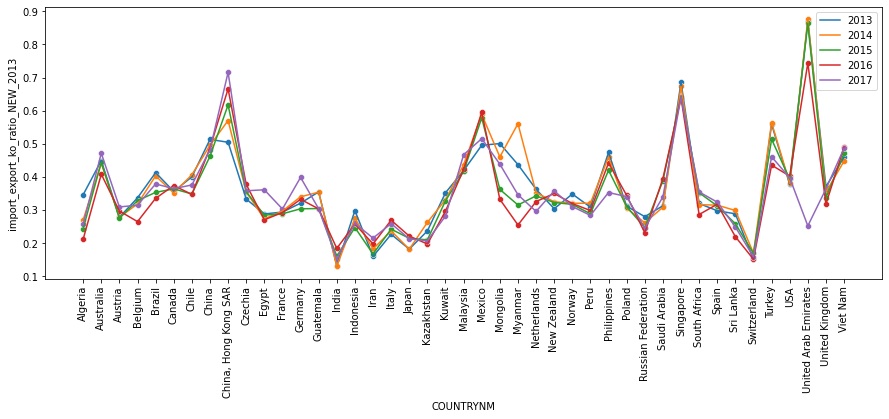

In [106]:
plt.figure(figsize=(15, 5))
labels = [i for i in range(2013, 2018)]
for i in range(1, len(labels)+1):
    sns.scatterplot(y = f.iloc[:, i], x=f.iloc[:, 0])
    sns.lineplot(y = f.iloc[:, i], x=f.iloc[:, 0], label=f'{labels[i-1]}')
plt.xticks(rotation=90)
plt.show()

# <font color='CC3D3D'>Merge Features

In [107]:
country_features = pd.concat(country_f_lst, axis=1).drop('COUNTRYNM', axis=1).set_index(country_f_lst[0].COUNTRYNM).reset_index()
continent_features = pd.concat(continent_f_lst, axis=1).drop('CONTINENT', axis=1).set_index(continent_f_lst[0].CONTINENT).reset_index()
hscd_name_features = pd.concat(hscd_name_f_lst, axis=1).drop('HSCD_name', axis=1).set_index(hscd_name_f_lst[0].HSCD_name).reset_index()

In [108]:
train_test = pd.merge(train_test, country_features, on='COUNTRYNM', how='left')
train_test = pd.merge(train_test, continent_features, on='CONTINENT', how='left')
train_test = pd.merge(train_test, hscd_name_features, on='HSCD_name', how='left')

#### Drop Columns

In [109]:
# 사용하지 않을 피쳐
drop_lst0 = ['UNC_YEAR', 'COUNTRYCD']

# 원핫 인코딩화된 피쳐
drop_lst1 = ['HSCD', 'HSCD_name', 'COUNTRYNM', 'CONTINENT']

# 파생변수를 만드는데 쓰인 train의 피쳐
drop_lst2 = ['TRADE_COUNTRYCD', 'TRADE_HSCD', 'NY_GDP_MKTP_CD', 'NY_GDP_MKTP_CD_1Y', 'TRADE_HSCD_COUNTRYCD']

# 파생변수를 만드는데 쓰인 크롤링된 피쳐
drop_lst3 = []
for dataset in add_dataset_lst:
    columns = pd.read_csv(dataset).columns.tolist()
    drop_lst3 += columns


# DROP FEATURES
drop_features = drop_lst0 + drop_lst1 + drop_lst2 + drop_lst3
train_test = train_test.drop(drop_features, axis=1)
print(train_test.shape)

# Check NaN for last
print('NaN:',train_test.isna().sum().sum())

(42378, 978)
NaN: 0


In [110]:
train_test.to_csv('features_Before_prepro_week4.csv', index=False)

# ────────────────── End of Pipeline1/3 ──────────────────